# llc4320 drifters spectra: Lagrangian vs Eulerian

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd
from xhistogram.xarray import histogram
%matplotlib inline
from matplotlib import pyplot as plt
from cmocean import cm
import matplotlib.colors as colors

import mitequinox.utils as ut
import mitequinox.parcels as pa
import mitequinox.drifters as dr

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.6116796.datarmor0/parcels-502027/libparcels_random_f7af5a22-8c96-46eb-8ed8-48049707ef0e.so


In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    cluster = PBSCluster(cores=28, processes=14) # necessary?
    w = cluster.scale(jobs=1)
    # 3 needed for lagrangian lon/lat binning
    # 15 for eulerian binning
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [3]:
client

<Client: 'tcp://10.148.0.251:40506' processes=14 threads=28, memory=111.72 GiB>

______________
## lat*lon maps

In [4]:
E = '/home/datawork-lops-osi/equinox/mit4320/diags'
L = '/home/datawork-lops-osi/equinox/mit4320/parcels/global_extra_T365j_dt1j_dij50/diagnostics'

In [5]:
E_Eulerian = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T60_lat_lon_bands.zarr'))
E_Eulerian = (E_Eulerian.rename({'lat_bin':'lat_bins', 'lon_bin': 'lon_bins', 'E_SSUV':'E_Eulerian'}))
E_Eulerian

<xarray.Dataset>
Dimensions:         (frequency_band: 14, lat_bins: 119, lon_bins: 359)
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'
  * lat_bins        (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5
  * lon_bins        (lon_bins) float64 -179.5 -178.5 -177.5 ... 177.5 178.5
Data variables:
    E_Eulerian      (frequency_band, lon_bins, lat_bins) float64 dask.array<chunksize=(7, 180, 60), meta=np.ndarray>

In [6]:
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['trajectory'])
E_lagrangian = p.load_diagnostic('spectra_uv_T60_mean0_lat_lon_bands.zarr')
E_lagrangian = E_lagrangian.rename({'E':'E_Lagrangian'})
E_lagrangian = E_lagrangian.E_Lagrangian
E_lagrangian

<xarray.DataArray 'E_Lagrangian' (frequency_band: 14, lon_bins: 359, lat_bins: 119)>
dask.array<open_dataset-6fdd392cb5b38dcff01e01286977fd97E, shape=(14, 359, 119), dtype=float64, chunksize=(1, 359, 60), chunktype=numpy.ndarray>
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'
  * lat_bins        (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5
  * lon_bins        (lon_bins) float64 -179.5 -178.5 -177.5 ... 177.5 178.5

In [7]:
# 2D binned Depth
V = ["SSUV"]
T = ["T60"]

sub = 1
dl = 1.
lon = np.arange(-180.,180., dl)
lat = np.arange(-60., 60., dl)
    
for v in V:
    for t in T:
        
        # read data
        ds = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/spectra_%s_%s.zarr'%(v,t)))
        ds = ds.isel(i=slice(0,None,sub),j=slice(0,None,sub))
        #ds = ds.where(ds.Depth>500, drop=False)
        #ds = ds.load()
        
        # lat, lon binning
        ds['lon'] = 0*ds.face+ds.XC
        ds['lat'] = 0*ds.face+ds.YC
        N = histogram(
                      ds.lon.load(), ds.lat.load(), 
                      bins=[lon, lat], 
                      dim=['i', 'j', 'face'], 
                      block_size=None
                     )

        E = histogram(
                      ds.lon.load(), ds.lat.load(),
                      bins=[lon, lat], 
                      weights= ds.Depth.load(), 
                      dim=['i', 'j', 'face'], 
                      block_size=None
                     )
        
        # get binned results
        Depth_bin = (E/N).rename('E_depth').rename({'lon_bin': 'lon_bins','lat_bin': 'lat_bins'})        

In [8]:
ds_E = xr.merge([E_Eulerian,E_lagrangian,Depth_bin])
ds_E

<xarray.Dataset>
Dimensions:         (frequency_band: 14, lat_bins: 119, lon_bins: 359)
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'
  * lat_bins        (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5
  * lon_bins        (lon_bins) float64 -179.5 -178.5 -177.5 ... 177.5 178.5
Data variables:
    E_Eulerian      (frequency_band, lon_bins, lat_bins) float64 dask.array<chunksize=(7, 180, 60), meta=np.ndarray>
    E_Lagrangian    (frequency_band, lon_bins, lat_bins) float64 dask.array<chunksize=(1, 359, 60), meta=np.ndarray>
    E_depth         (lon_bins, lat_bins) float64 4.548e+03 ... 3.74e+03

# Figures

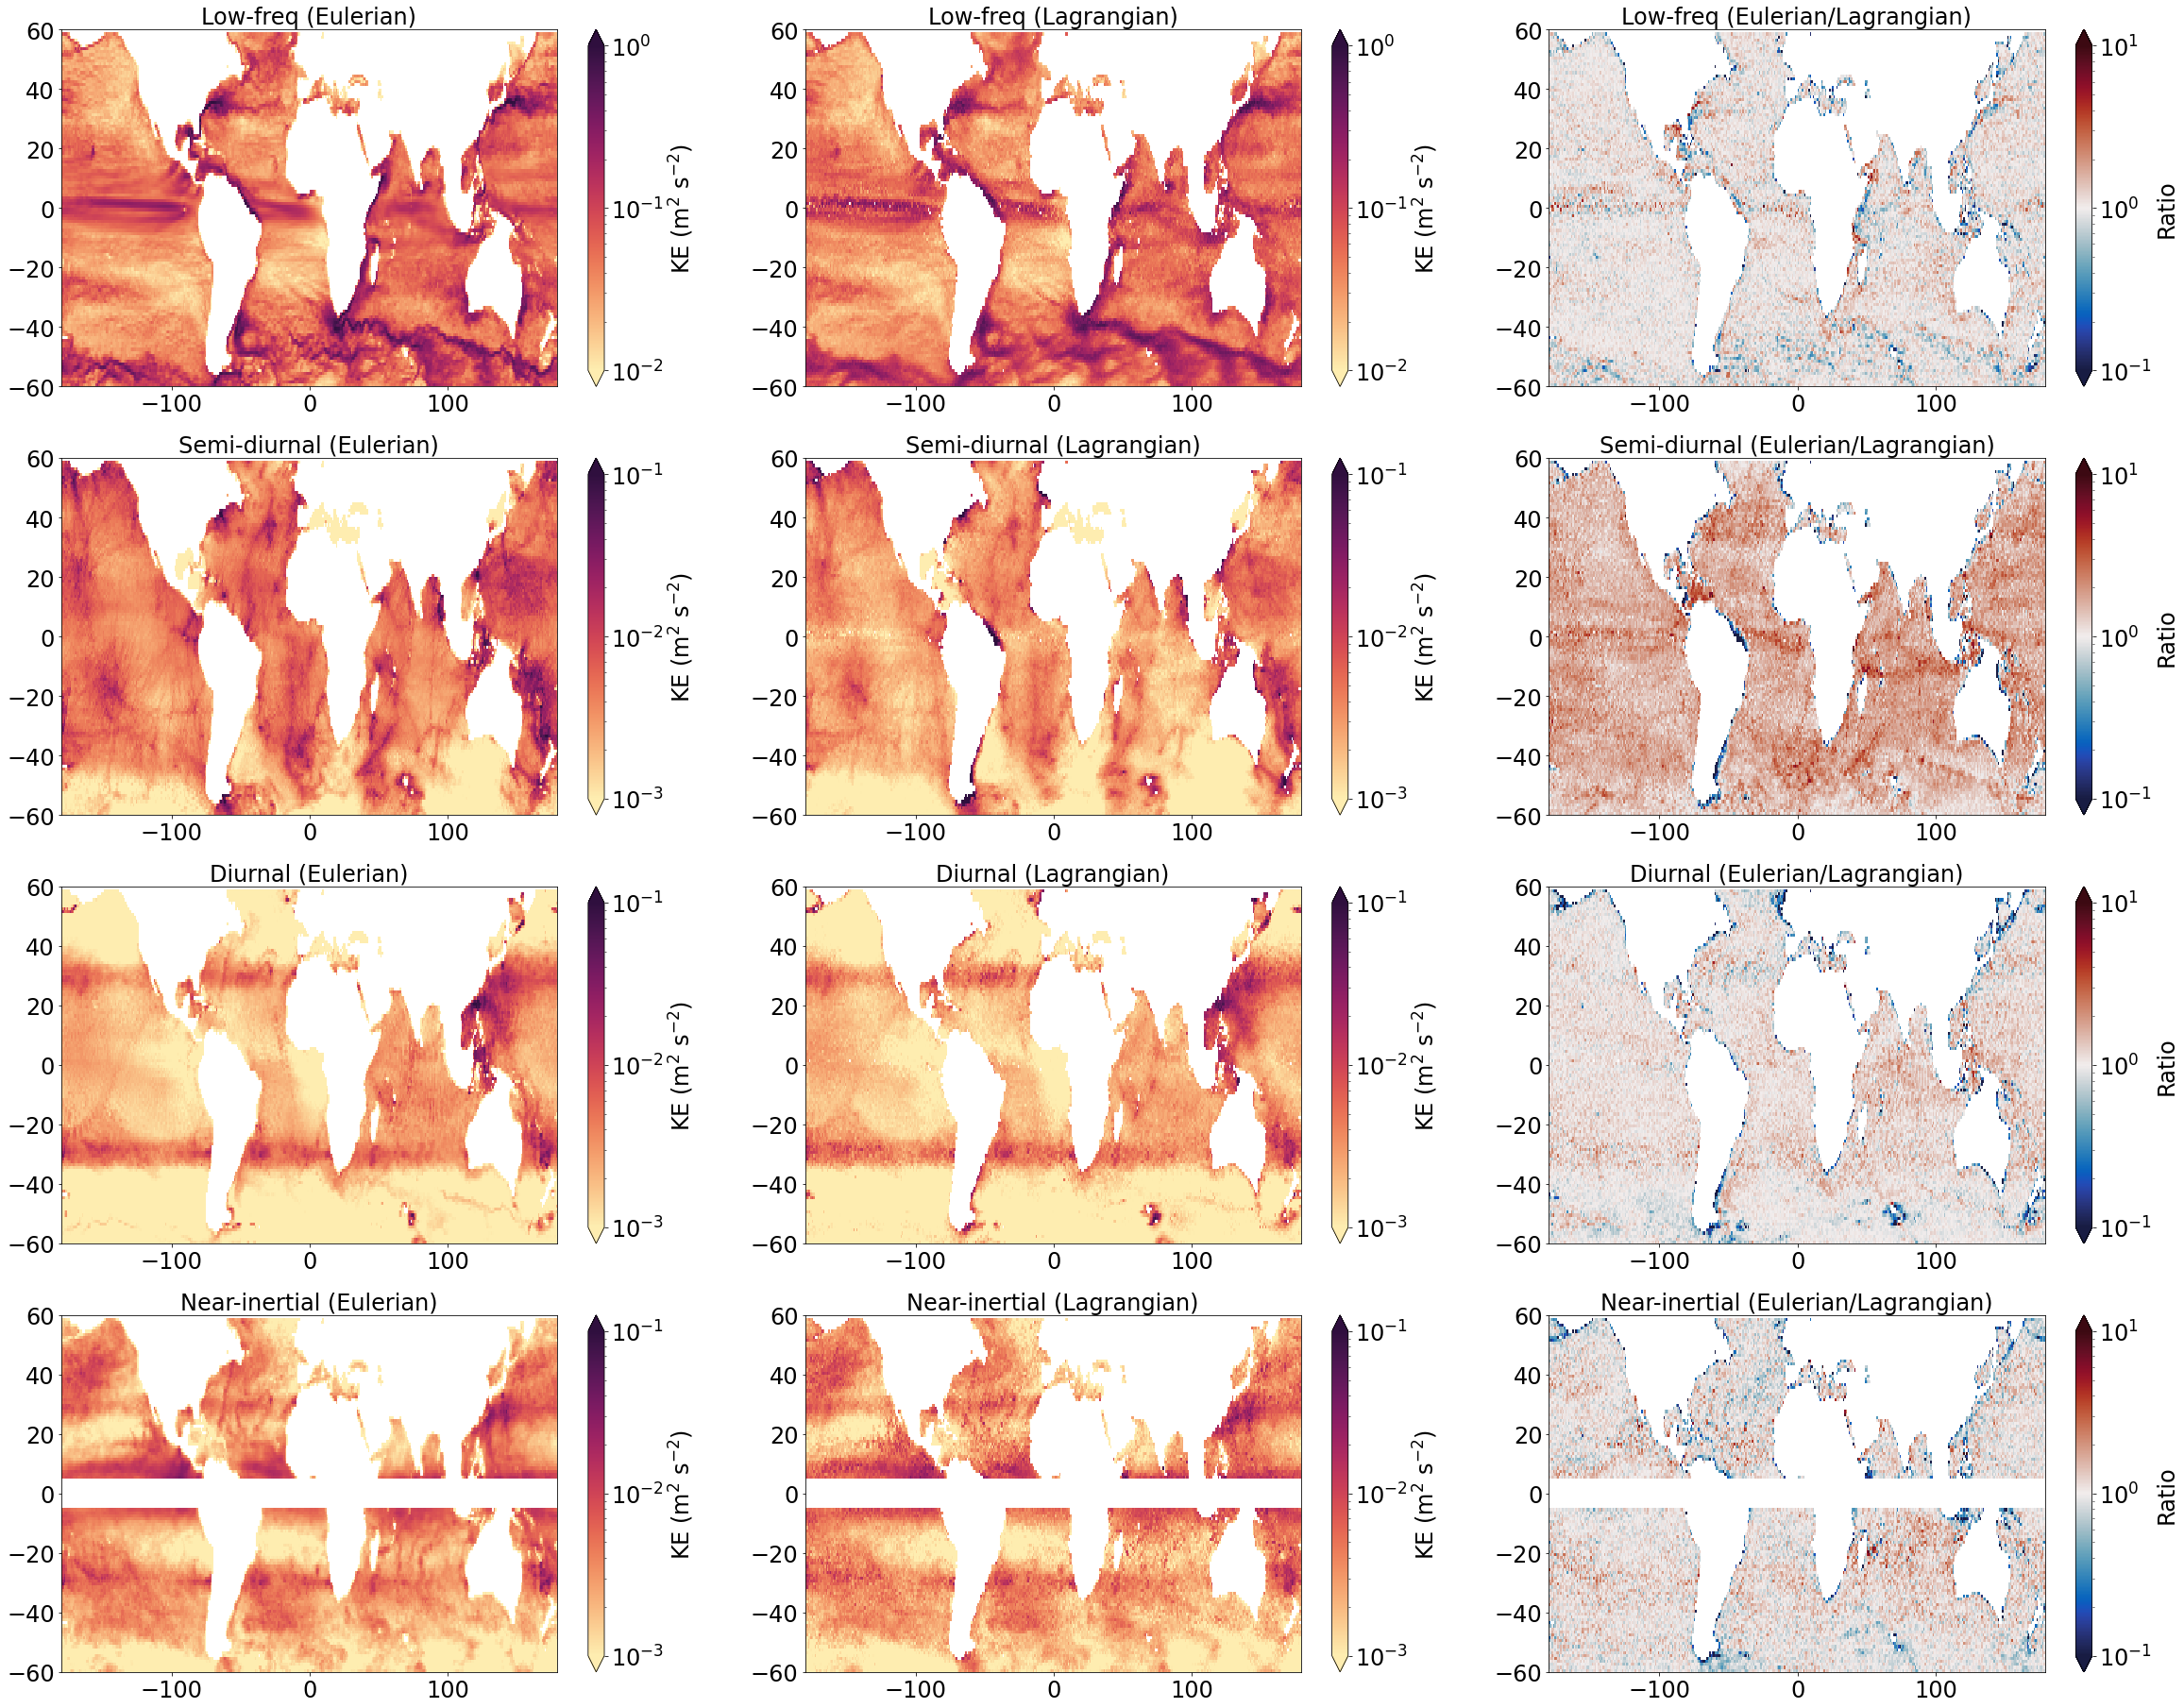

In [27]:
# bandwidth +-0.1
font_size = 24
fig, ax = plt.subplots(figsize=(40,32))

ax = plt.subplot(431)
cax=(E_Eulerian.E_SSUV.sel(frequency_band='low')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-2, vmax=1e0), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Low-freq (Eulerian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(434)
cax=(E_Eulerian.E_SSUV.sel(frequency_band='semidiurnal_0dot1')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Semi-diurnal (Eulerian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(437)
cax=(E_Eulerian.E_SSUV.sel(frequency_band='diurnal_0dot1')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Diurnal (Eulerian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(4,3,10)
cax=(E_Eulerian.E_SSUV.sel(frequency_band='inertial_0dot1').where(np.abs(E_Eulerian.lat_bins)>5)).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Near-inertial (Eulerian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)




ax = plt.subplot(432)
cax=(E_lagrangian.sel(frequency_band='low')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-2, vmax=1e0), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Low-freq (Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(435)
cax=(E_lagrangian.sel(frequency_band='semidiurnal_0dot1')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Semi-diurnal (Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(438)
cax=(E_lagrangian.sel(frequency_band='diurnal_0dot1')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Diurnal (Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(4,3,11)
cax=(E_lagrangian.sel(frequency_band='inertial_0dot1').where(np.abs(E_lagrangian.lat_bins)>5)).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Near-inertial (Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)




ax = plt.subplot(433)
cax = (E_Eulerian.E_SSUV.sel(frequency_band='low')/E_lagrangian.sel(frequency_band='low')).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
ax.set_title('Low-freq (Eulerian/Lagrangian)',fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
cbar.set_label('Ratio', fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(436)
cax = (E_Eulerian.E_SSUV.sel(frequency_band='semidiurnal_0dot1')/E_lagrangian.sel(frequency_band='semidiurnal_0dot1')).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Semi-diurnal (Eulerian/Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(439)
cax = (E_Eulerian.E_SSUV.sel(frequency_band='diurnal_0dot1')/E_lagrangian.sel(frequency_band='diurnal_0dot1')).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Diurnal (Eulerian/Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(4,3,12)
cax = (E_Eulerian.E_SSUV.sel(frequency_band='inertial_0dot1')/E_lagrangian.sel(frequency_band='inertial_0dot1')).where(np.abs(E_Eulerian.lat_bins)>5).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Near-inertial (Eulerian/Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)


plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Band_integral_LLC_0dot1.png')

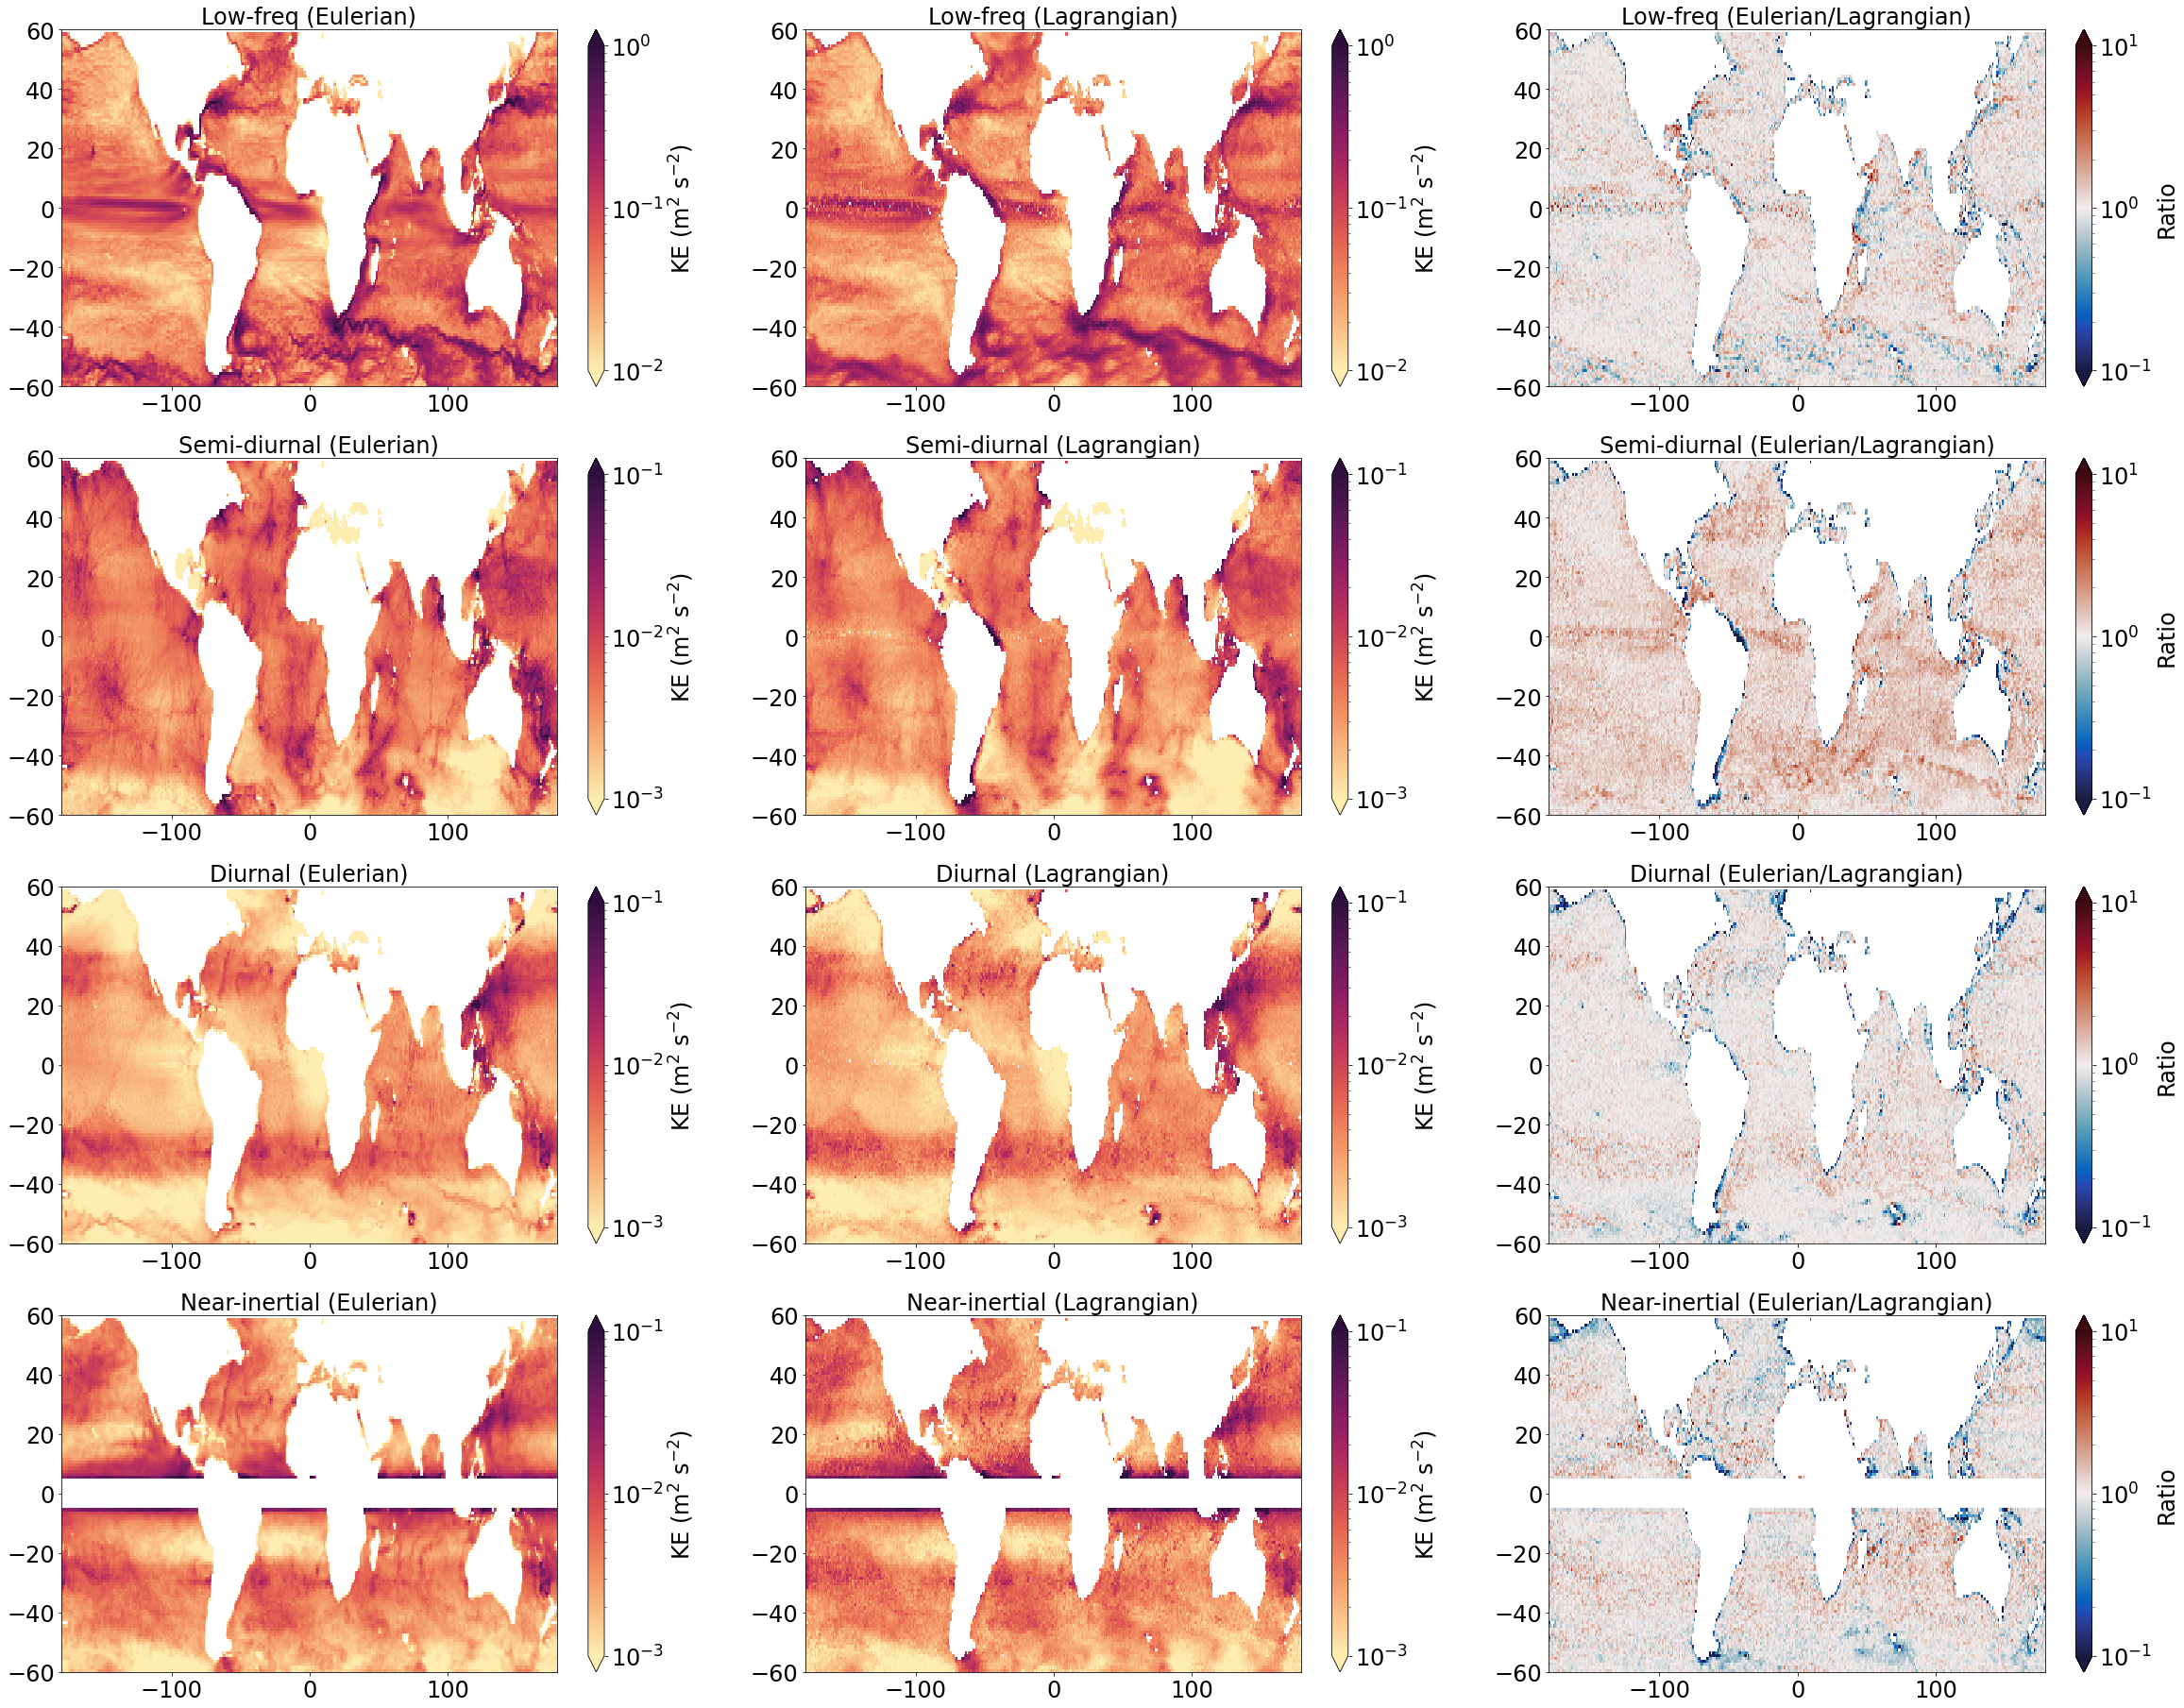

In [28]:
# bandwidth +-0.2
font_size = 24
fig, ax = plt.subplots(figsize=(40,32))

ax = plt.subplot(431)
cax=(E_Eulerian.E_SSUV.sel(frequency_band='low')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-2, vmax=1e0), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Low-freq (Eulerian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(434)
cax=(E_Eulerian.E_SSUV.sel(frequency_band='semidiurnal_0dot2')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Semi-diurnal (Eulerian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(437)
cax=(E_Eulerian.E_SSUV.sel(frequency_band='diurnal_0dot2')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Diurnal (Eulerian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(4,3,10)
cax=(E_Eulerian.E_SSUV.sel(frequency_band='inertial_0dot2').where(np.abs(E_Eulerian.lat_bins)>5)).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Near-inertial (Eulerian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)




ax = plt.subplot(432)
cax=(E_lagrangian.sel(frequency_band='low')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-2, vmax=1e0), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Low-freq (Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(435)
cax=(E_lagrangian.sel(frequency_band='semidiurnal_0dot2')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Semi-diurnal (Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(438)
cax=(E_lagrangian.sel(frequency_band='diurnal_0dot2')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Diurnal (Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(4,3,11)
cax=(E_lagrangian.sel(frequency_band='inertial_0dot2').where(np.abs(E_lagrangian.lat_bins)>5)).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Near-inertial (Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)




ax = plt.subplot(433)
cax = (E_Eulerian.E_SSUV.sel(frequency_band='low')/E_lagrangian.sel(frequency_band='low')).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
ax.set_title('Low-freq (Eulerian/Lagrangian)',fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
cbar.set_label('Ratio', fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(436)
cax = (E_Eulerian.E_SSUV.sel(frequency_band='semidiurnal_0dot2')/E_lagrangian.sel(frequency_band='semidiurnal_0dot2')).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Semi-diurnal (Eulerian/Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(439)
cax = (E_Eulerian.E_SSUV.sel(frequency_band='diurnal_0dot2')/E_lagrangian.sel(frequency_band='diurnal_0dot2')).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Diurnal (Eulerian/Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(4,3,12)
cax = (E_Eulerian.E_SSUV.sel(frequency_band='inertial_0dot2')/E_lagrangian.sel(frequency_band='inertial_0dot2')).where(np.abs(E_Eulerian.lat_bins)>5).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Near-inertial (Eulerian/Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Band_integral_LLC_0dot2.png')

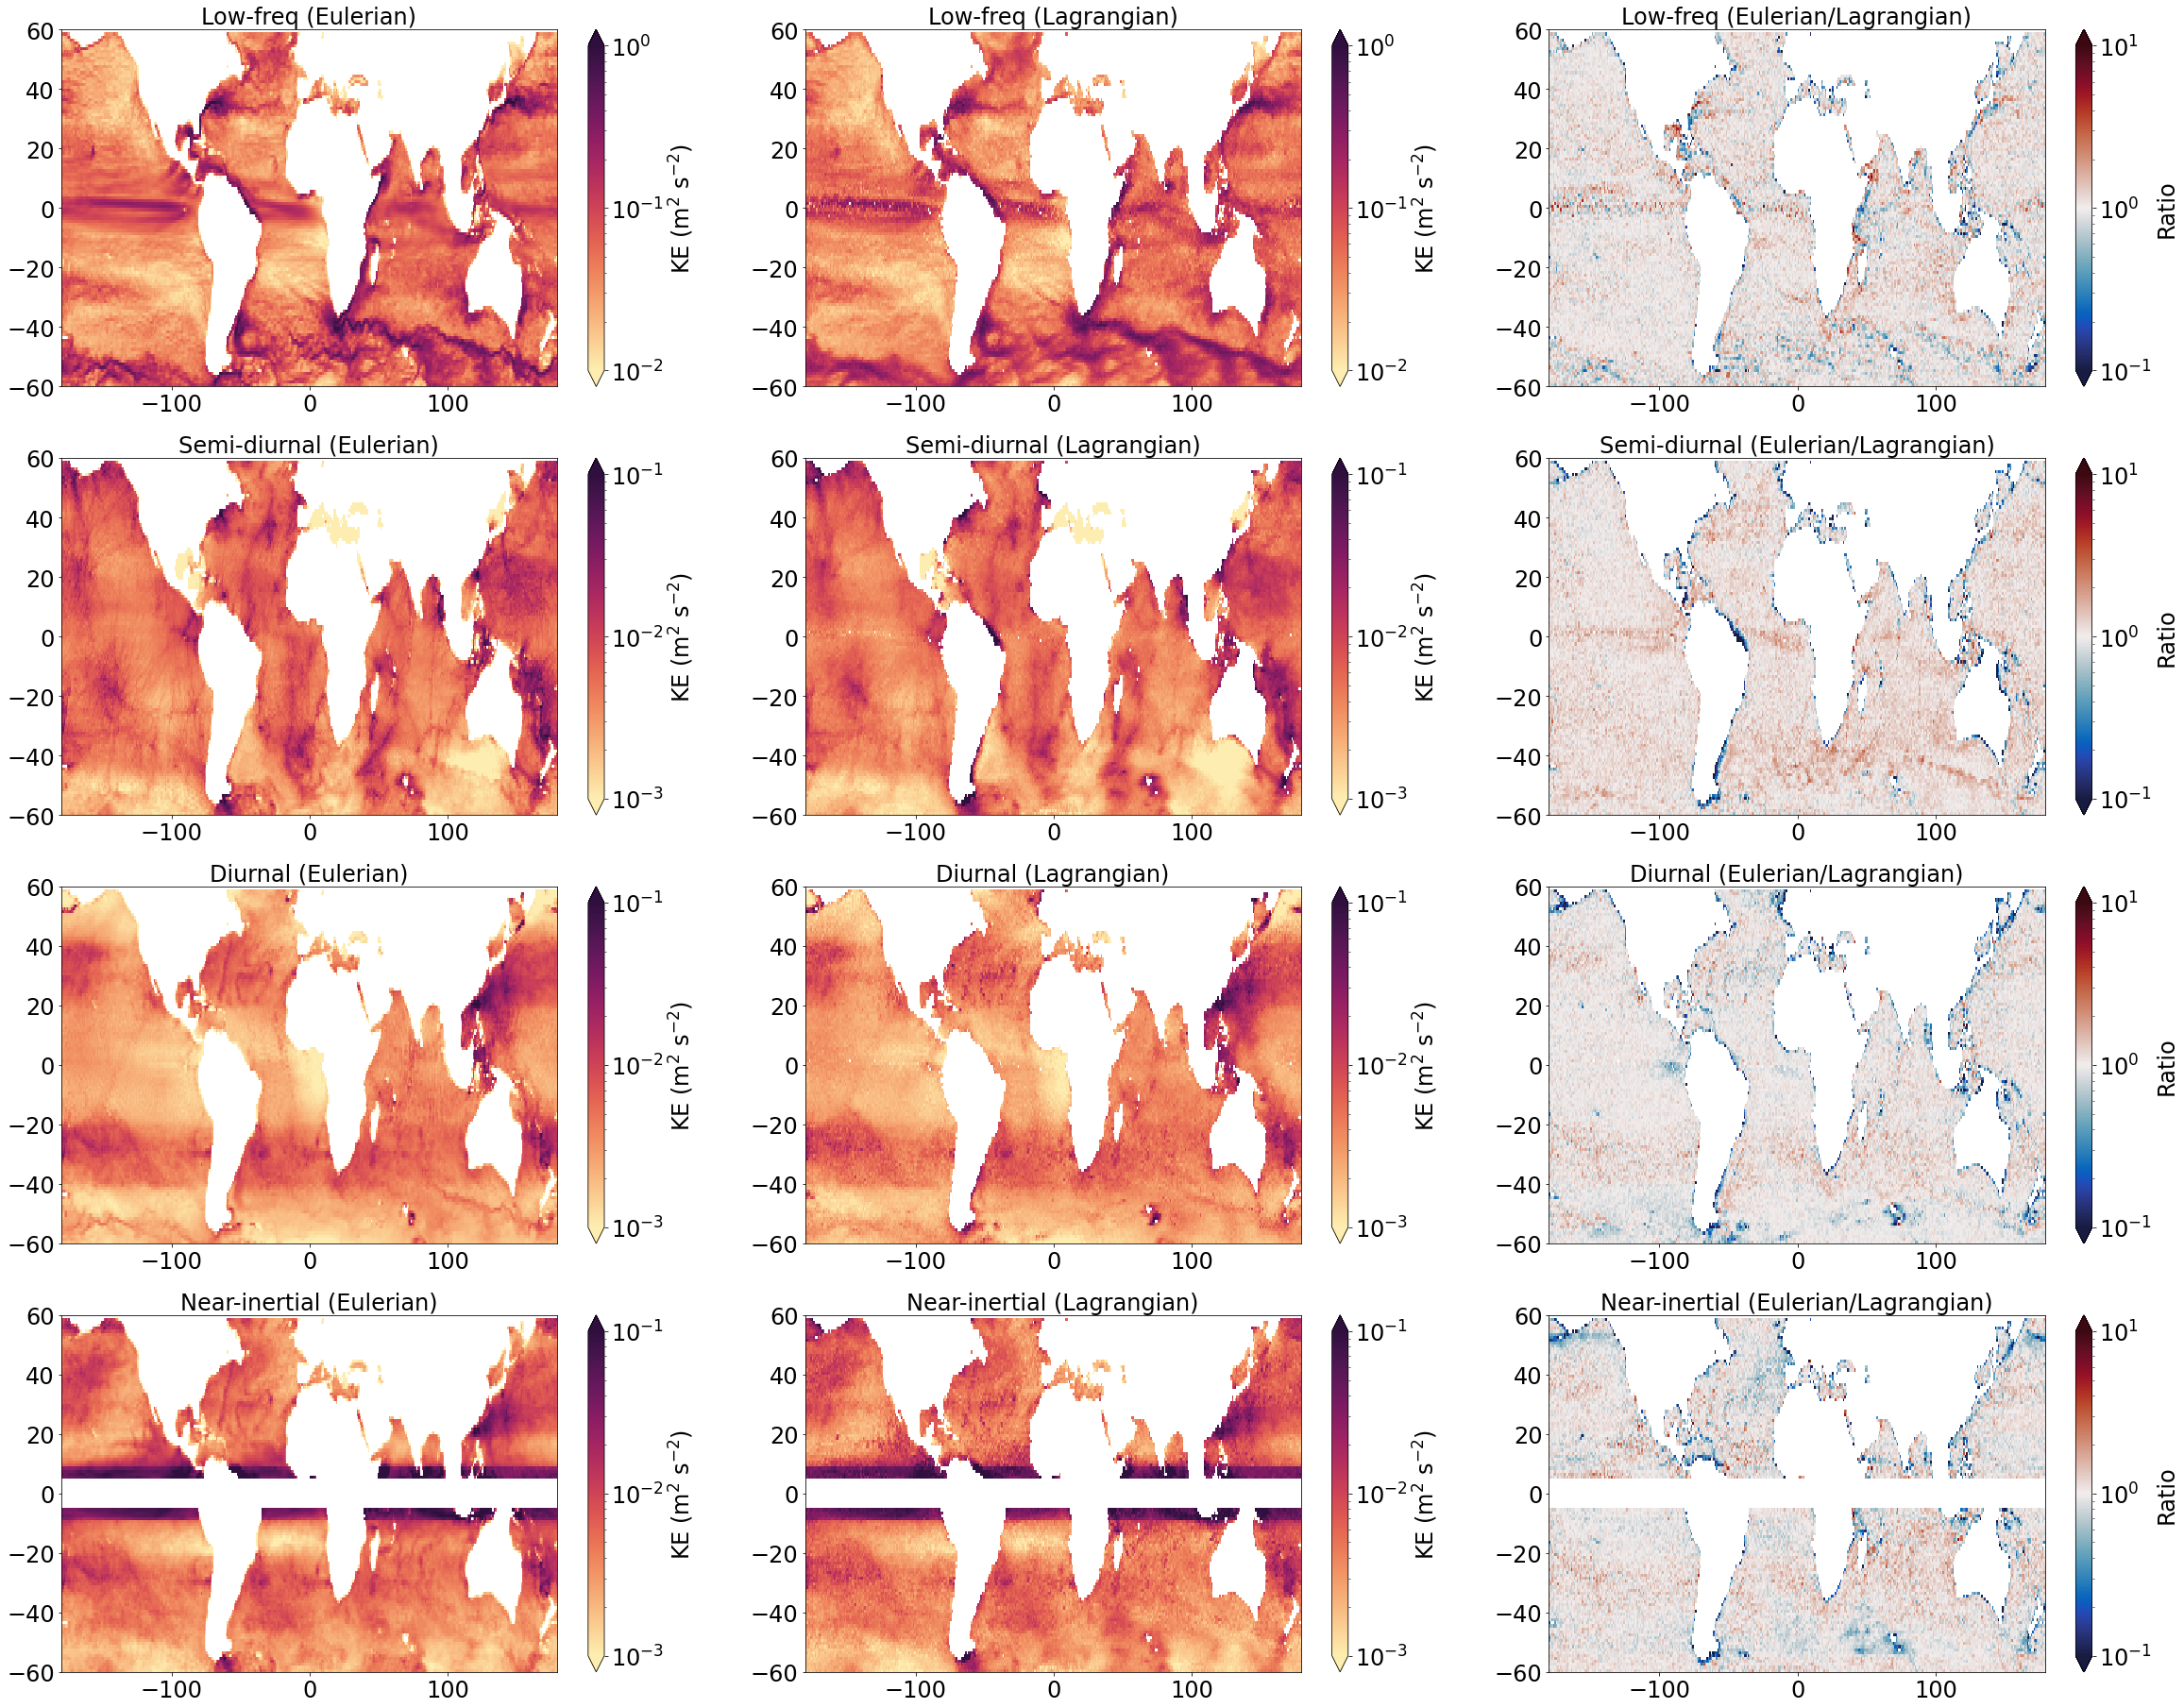

In [14]:
# # bandwidth +-0.3
font_size = 24
fig, ax = plt.subplots(figsize=(40,32))

ax = plt.subplot(431)
cax=(E_Eulerian.E_SSUV.sel(frequency_band='low')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-2, vmax=1e0), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Low-freq (Eulerian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(434)
cax=(E_Eulerian.E_SSUV.sel(frequency_band='semidiurnal_0dot3')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Semi-diurnal (Eulerian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(437)
cax=(E_Eulerian.E_SSUV.sel(frequency_band='diurnal_0dot3')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Diurnal (Eulerian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(4,3,10)
cax=(E_Eulerian.E_SSUV.sel(frequency_band='inertial_0dot3').where(np.abs(E_Eulerian.lat_bins)>5)).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Near-inertial (Eulerian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)




ax = plt.subplot(432)
cax=(E_lagrangian.sel(frequency_band='low')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-2, vmax=1e0), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Low-freq (Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(435)
cax=(E_lagrangian.sel(frequency_band='semidiurnal_0dot3')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Semi-diurnal (Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(438)
cax=(E_lagrangian.sel(frequency_band='diurnal_0dot3')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Diurnal (Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(4,3,11)
cax=(E_lagrangian.sel(frequency_band='inertial_0dot3').where(np.abs(E_lagrangian.lat_bins)>5)).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Near-inertial (Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)




ax = plt.subplot(433)
cax = (E_Eulerian.E_SSUV.sel(frequency_band='low')/E_lagrangian.sel(frequency_band='low')).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
ax.set_title('Low-freq (Eulerian/Lagrangian)',fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
cbar.set_label('Ratio', fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(436)
cax = (E_Eulerian.E_SSUV.sel(frequency_band='semidiurnal_0dot3')/E_lagrangian.sel(frequency_band='semidiurnal_0dot3')).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Semi-diurnal (Eulerian/Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(439)
cax = (E_Eulerian.E_SSUV.sel(frequency_band='diurnal_0dot3')/E_lagrangian.sel(frequency_band='diurnal_0dot3')).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Diurnal (Eulerian/Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(4,3,12)
cax = (E_Eulerian.E_SSUV.sel(frequency_band='inertial_0dot3')/E_lagrangian.sel(frequency_band='inertial_0dot3')).where(np.abs(E_Eulerian.lat_bins)>5).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Near-inertial (Eulerian/Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Band_integral_LLC_0dot3.png')

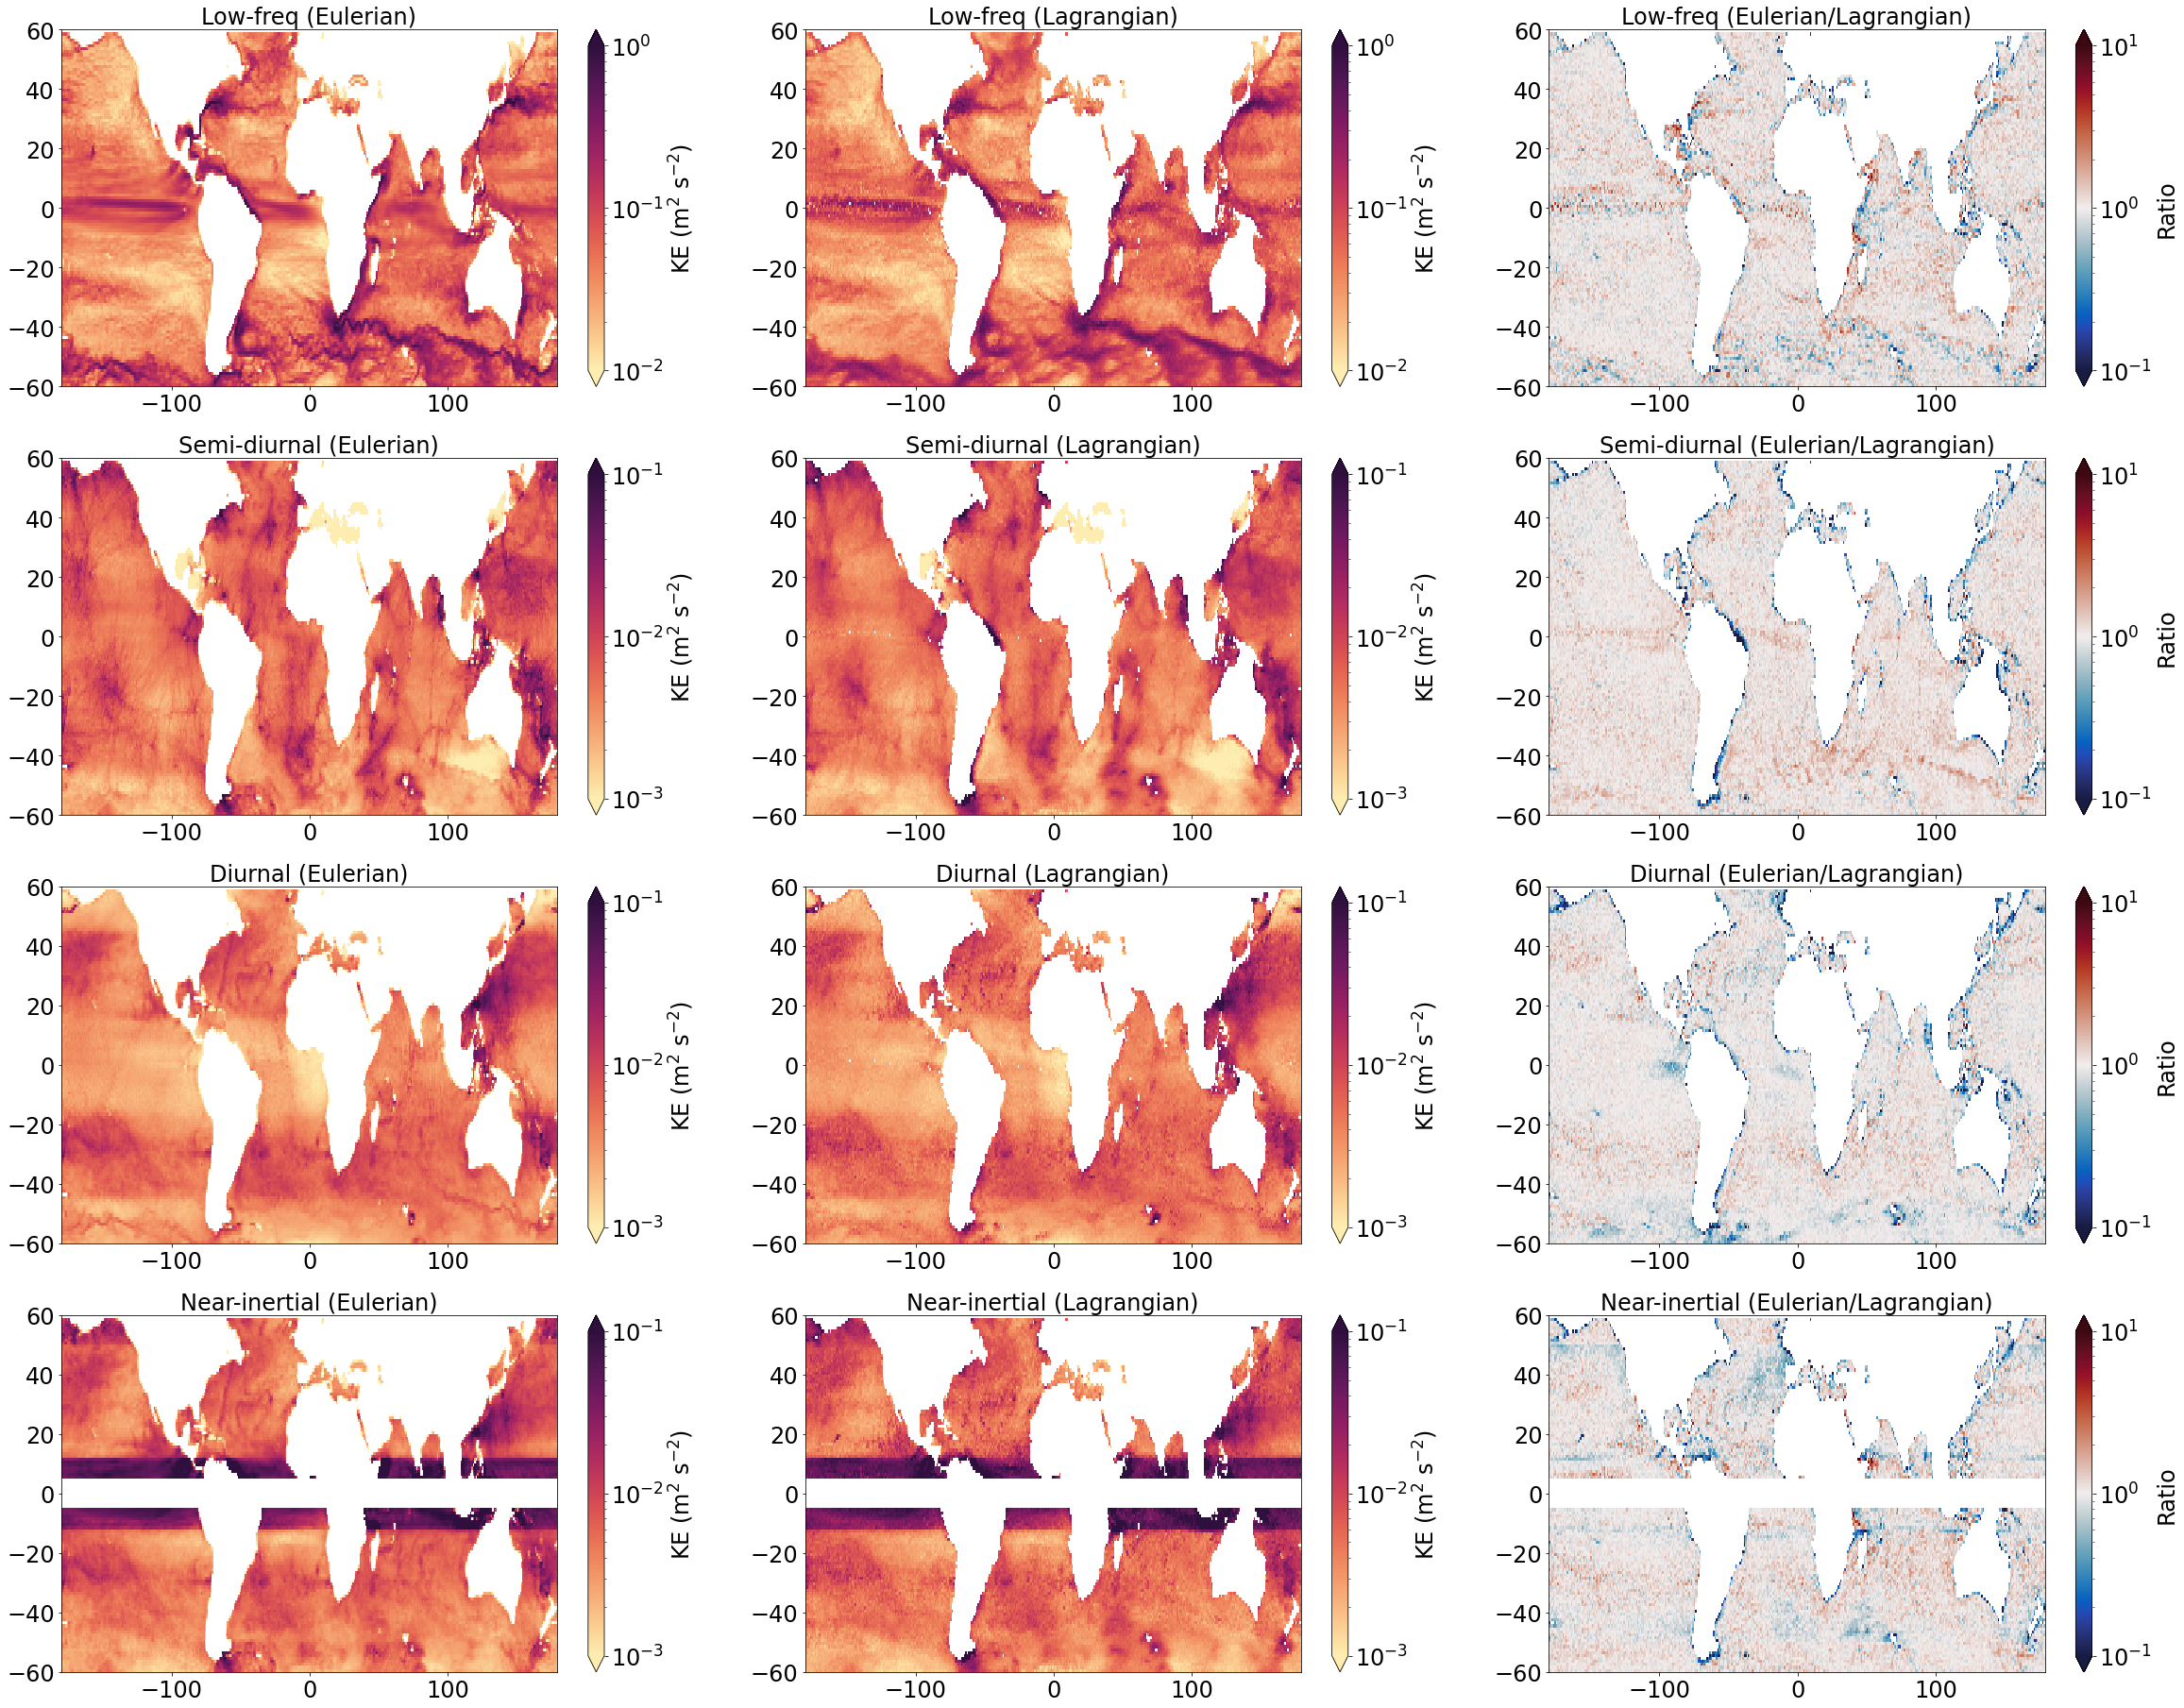

In [15]:
# bandwidth +-0.4

font_size = 24
fig, ax = plt.subplots(figsize=(40,32))

ax = plt.subplot(431)
cax=(E_Eulerian.E_SSUV.sel(frequency_band='low')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-2, vmax=1e0), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Low-freq (Eulerian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(434)
cax=(E_Eulerian.E_SSUV.sel(frequency_band='semidiurnal_0dot4')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Semi-diurnal (Eulerian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(437)
cax=(E_Eulerian.E_SSUV.sel(frequency_band='diurnal_0dot4')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Diurnal (Eulerian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(4,3,10)
cax=(E_Eulerian.E_SSUV.sel(frequency_band='inertial_0dot4').where(np.abs(E_Eulerian.lat_bins)>5)).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Near-inertial (Eulerian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)




ax = plt.subplot(432)
cax=(E_lagrangian.sel(frequency_band='low')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-2, vmax=1e0), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Low-freq (Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(435)
cax=(E_lagrangian.sel(frequency_band='semidiurnal_0dot4')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Semi-diurnal (Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(438)
cax=(E_lagrangian.sel(frequency_band='diurnal_0dot4')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Diurnal (Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(4,3,11)
cax=(E_lagrangian.sel(frequency_band='inertial_0dot4').where(np.abs(E_lagrangian.lat_bins)>5)).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Near-inertial (Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)




ax = plt.subplot(433)
cax = (E_Eulerian.E_SSUV.sel(frequency_band='low')/E_lagrangian.sel(frequency_band='low')).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
ax.set_title('Low-freq (Eulerian/Lagrangian)',fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
cbar.set_label('Ratio', fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(436)
cax = (E_Eulerian.E_SSUV.sel(frequency_band='semidiurnal_0dot4')/E_lagrangian.sel(frequency_band='semidiurnal_0dot4')).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Semi-diurnal (Eulerian/Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(439)
cax = (E_Eulerian.E_SSUV.sel(frequency_band='diurnal_0dot4')/E_lagrangian.sel(frequency_band='diurnal_0dot4')).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Diurnal (Eulerian/Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(4,3,12)
cax = (E_Eulerian.E_SSUV.sel(frequency_band='inertial_0dot4')/E_lagrangian.sel(frequency_band='inertial_0dot4')).where(np.abs(E_Eulerian.lat_bins)>5).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Near-inertial (Eulerian/Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Band_integral_LLC_0dot4.png')

## 2D Histogram

In [42]:
x_bins = np.arange(0, 0.025, 0.001)
y_bins = np.arange(0, 0.025, 0.001)

SD_01cpd = histogram(ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot1'),
                     ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot1'),
                     bins=[x_bins, y_bins],
                     block_size=None)

SD_02cpd = histogram(ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot2'),
                     ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot2'),
                     bins=[x_bins, y_bins],
                     block_size=None)

SD_03cpd = histogram(ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot3'),
                     ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot3'),
                     bins=[x_bins, y_bins],
                     block_size=None)

SD_04cpd = histogram(ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot4'),
                     ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot4'),
                     bins=[x_bins, y_bins],
                     block_size=None)

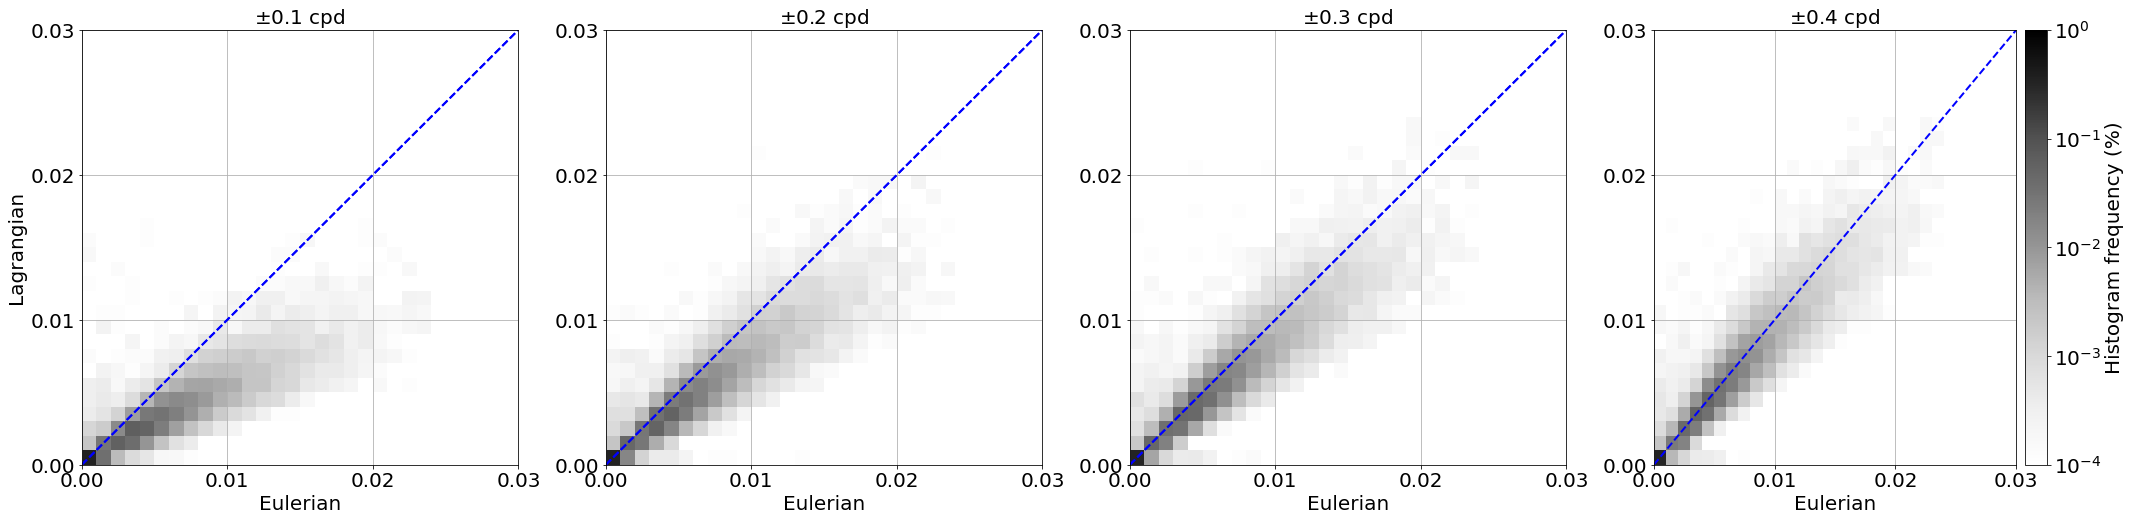

In [43]:
# Histogram for lat*lon KE
plt.rc('font', size=20) 
font_size = 20
vmin = -4
vmax = 0
cmap = 'Greys'
color = "b"
lims = (0, .03)


fig = plt.figure(figsize=(36,8))
ax = plt.subplot(141)
cax = np.log10(SD_01cpd/SD_01cpd.sum()).plot(x='E_Eulerian_bin',y='E_Lagrangian_bin',cmap=cmap,vmin=vmin,vmax=vmax, add_colorbar = False) 
ax.grid()
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel('Lagrangian',fontsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xticks([0, 0.01,0.02,0.03])
ax.set_yticks([0, 0.01,0.02,0.03])
ax.set_title('$\pm$0.1 cpd',fontsize=font_size)

ax = plt.subplot(142)
cax = np.log10(SD_02cpd/SD_02cpd.sum()).plot(x='E_Eulerian_bin',y='E_Lagrangian_bin',cmap=cmap,vmin=vmin,vmax=vmax, add_colorbar = False) 
ax.grid()
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xticks([0, 0.01,0.02,0.03])
ax.set_yticks([0, 0.01,0.02,0.03])
ax.set_title('$\pm$0.2 cpd',fontsize=font_size)

ax = plt.subplot(143)
cax = np.log10(SD_03cpd/SD_03cpd.sum()).plot(x='E_Eulerian_bin',y='E_Lagrangian_bin',cmap=cmap,vmin=vmin,vmax=vmax, add_colorbar = False) 
ax.grid()
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xticks([0, 0.01,0.02,0.03])
ax.set_yticks([0, 0.01,0.02,0.03])
ax.set_title('$\pm$0.3 cpd',fontsize=font_size)

ax = plt.subplot(144)
cax = np.log10(SD_04cpd/SD_04cpd.sum()).plot(x='E_Eulerian_bin',y='E_Lagrangian_bin',cmap=cmap,vmin=vmin,vmax=vmax, add_colorbar = False) 
cbar = plt.colorbar(cax, ax=ax, orientation='vertical', ticks=[-4, -3, -2, -1, 0], pad=0.02)
cbar.set_ticklabels(['10$^{-4}$','10$^{-3}$','10$^{-2}$','10$^{-1}$','10$^{0}$'])
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Histogram frequency (%)', fontsize=font_size)
ax.grid()
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xticks([0, 0.01,0.02,0.03])
ax.set_yticks([0, 0.01,0.02,0.03])
ax.set_title('$\pm$0.4 cpd',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/KE_2D_histogram_SD.png')

In [30]:
x_bins = np.arange(0, 0.025, 0.001)
y_bins = np.arange(0, 0.025, 0.001)

D_01cpd = histogram(ds_E.E_Eulerian.sel(frequency_band='diurnal_0dot1'),
                     ds_E.E_Lagrangian.sel(frequency_band='diurnal_0dot1'),
                     bins=[x_bins, y_bins],
                     block_size=None)

D_02cpd = histogram(ds_E.E_Eulerian.sel(frequency_band='diurnal_0dot2'),
                     ds_E.E_Lagrangian.sel(frequency_band='diurnal_0dot2'),
                     bins=[x_bins, y_bins],
                     block_size=None)

D_03cpd = histogram(ds_E.E_Eulerian.sel(frequency_band='diurnal_0dot3'),
                     ds_E.E_Lagrangian.sel(frequency_band='diurnal_0dot3'),
                     bins=[x_bins, y_bins],
                     block_size=None)

D_04cpd = histogram(ds_E.E_Eulerian.sel(frequency_band='diurnal_0dot4'),
                     ds_E.E_Lagrangian.sel(frequency_band='diurnal_0dot4'),
                     bins=[x_bins, y_bins],
                     block_size=None)

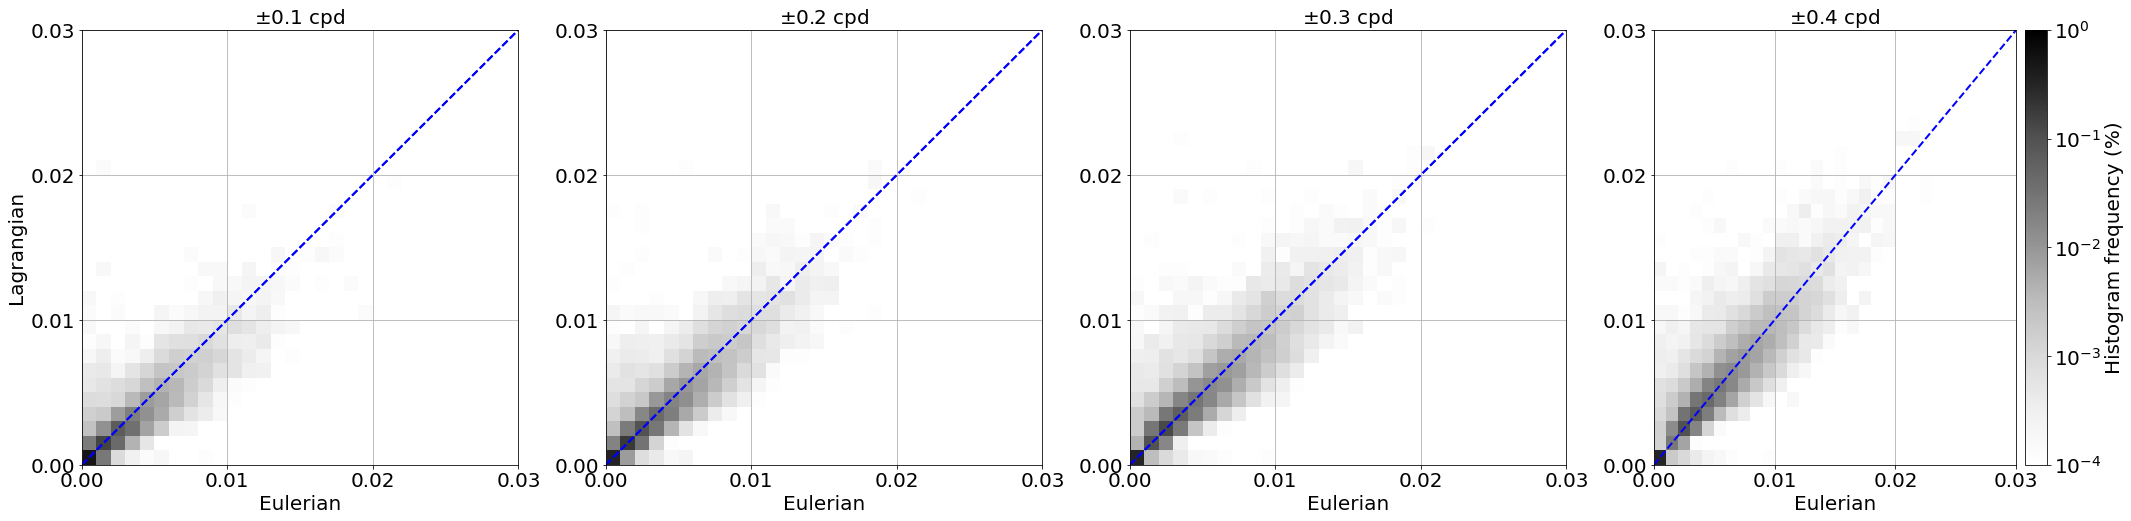

In [44]:
# Histogram for lat*lon KE
plt.rc('font', size=20) 
font_size = 20
vmin = -4
vmax = 0
cmap = 'Greys'
color = "b"
lims = (0, .03)

fig = plt.figure(figsize=(36,8))
ax = plt.subplot(141)
cax = np.log10(D_01cpd/SD_01cpd.sum()).plot(x='E_Eulerian_bin',y='E_Lagrangian_bin',cmap=cmap,vmin=vmin,vmax=vmax, add_colorbar = False) 
ax.grid()
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel('Lagrangian',fontsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xticks([0, 0.01,0.02,0.03])
ax.set_yticks([0, 0.01,0.02,0.03])
ax.set_title('$\pm$0.1 cpd',fontsize=font_size)

ax = plt.subplot(142)
cax = np.log10(D_02cpd/SD_02cpd.sum()).plot(x='E_Eulerian_bin',y='E_Lagrangian_bin',cmap=cmap,vmin=vmin,vmax=vmax, add_colorbar = False) 
ax.grid()
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xticks([0, 0.01,0.02,0.03])
ax.set_yticks([0, 0.01,0.02,0.03])
ax.set_title('$\pm$0.2 cpd',fontsize=font_size)

ax = plt.subplot(143)
cax = np.log10(D_03cpd/SD_03cpd.sum()).plot(x='E_Eulerian_bin',y='E_Lagrangian_bin',cmap=cmap,vmin=vmin,vmax=vmax, add_colorbar = False) 
ax.grid()
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xticks([0, 0.01,0.02,0.03])
ax.set_yticks([0, 0.01,0.02,0.03])
ax.set_title('$\pm$0.3 cpd',fontsize=font_size)

ax = plt.subplot(144)
cax = np.log10(D_04cpd/SD_04cpd.sum()).plot(x='E_Eulerian_bin',y='E_Lagrangian_bin',cmap=cmap,vmin=vmin,vmax=vmax, add_colorbar = False) 
cbar = plt.colorbar(cax, ax=ax, orientation='vertical', ticks=[-4, -3, -2, -1, 0], pad=0.02)
cbar.set_ticklabels(['10$^{-4}$','10$^{-3}$','10$^{-2}$','10$^{-1}$','10$^{0}$'])
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Histogram frequency (%)', fontsize=font_size)
ax.grid()
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xticks([0, 0.01,0.02,0.03])
ax.set_yticks([0, 0.01,0.02,0.03])
ax.set_title('$\pm$0.4 cpd',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/KE_2D_histogram_D.png')

In [39]:
x_bins = np.arange(0, 0.025, 0.001)
y_bins = np.arange(0, 0.025, 0.001)

NI_01cpd = histogram(ds_E.E_Eulerian.sel(frequency_band='inertial_0dot1').where(np.abs(ds_E.lat_bins)>15),
                     ds_E.E_Lagrangian.sel(frequency_band='inertial_0dot1').where(np.abs(ds_E.lat_bins)>15),
                     bins=[x_bins, y_bins],
                     block_size=None)

NI_02cpd = histogram(ds_E.E_Eulerian.sel(frequency_band='inertial_0dot2').where(np.abs(ds_E.lat_bins)>15),
                     ds_E.E_Lagrangian.sel(frequency_band='inertial_0dot2').where(np.abs(ds_E.lat_bins)>15),
                     bins=[x_bins, y_bins],
                     block_size=None)

NI_03cpd = histogram(ds_E.E_Eulerian.sel(frequency_band='inertial_0dot3').where(np.abs(ds_E.lat_bins)>15),
                     ds_E.E_Lagrangian.sel(frequency_band='inertial_0dot3').where(np.abs(ds_E.lat_bins)>15),
                     bins=[x_bins, y_bins],
                     block_size=None)

NI_04cpd = histogram(ds_E.E_Eulerian.sel(frequency_band='inertial_0dot4').where(np.abs(ds_E.lat_bins)>15),
                     ds_E.E_Lagrangian.sel(frequency_band='inertial_0dot4').where(np.abs(ds_E.lat_bins)>15),
                     bins=[x_bins, y_bins],
                     block_size=None)

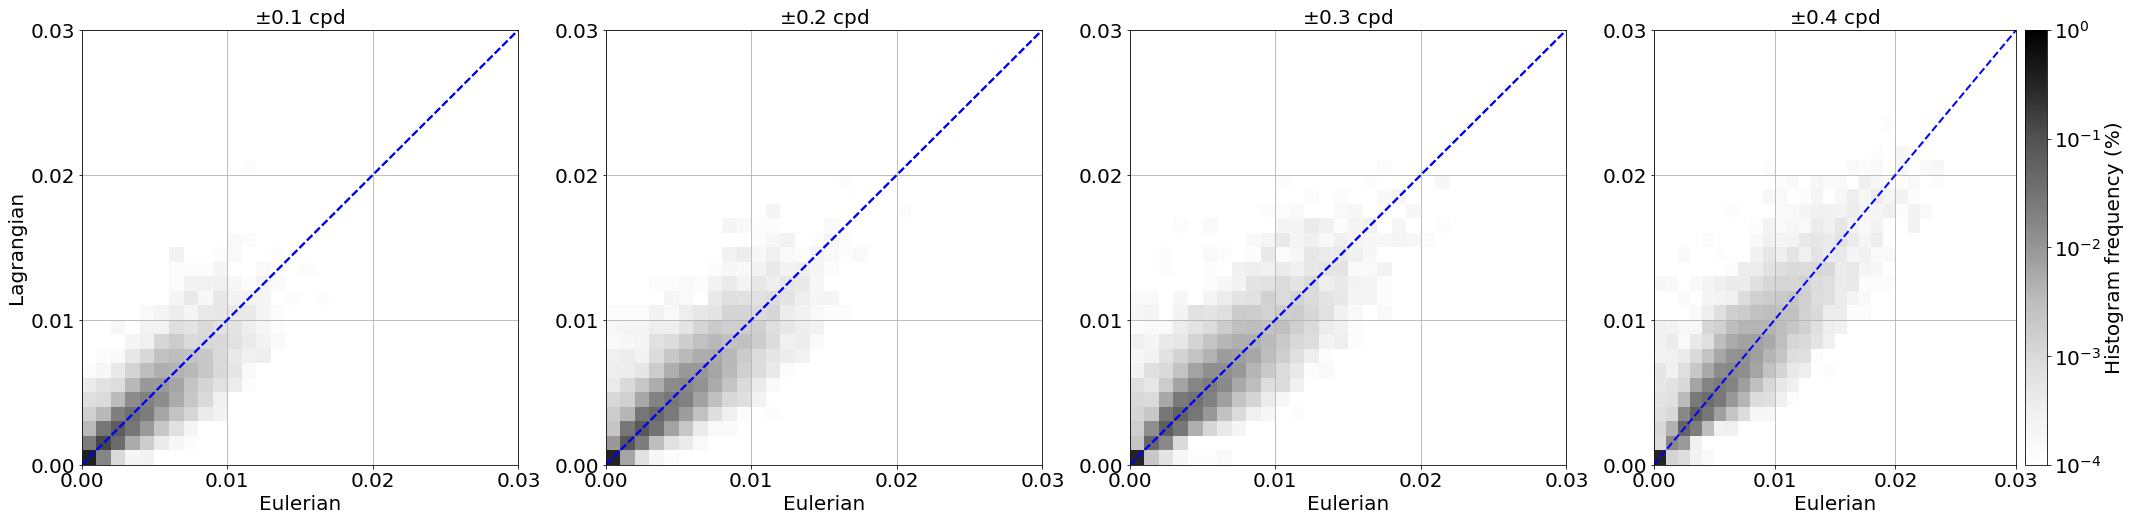

In [45]:
# Histogram for lat*lon KE
plt.rc('font', size=20) 
font_size = 20
vmin = -4
vmax = 0
cmap = 'Greys'
color = "b"
lims = (0, .03)

fig = plt.figure(figsize=(36,8))
ax = plt.subplot(141)
cax = np.log10(NI_01cpd/NI_01cpd.sum()).plot(x='E_Eulerian_bin',y='E_Lagrangian_bin',cmap=cmap,vmin=vmin,vmax=vmax, add_colorbar = False) 
ax.grid()
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel('Lagrangian',fontsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xticks([0, 0.01,0.02,0.03])
ax.set_yticks([0, 0.01,0.02,0.03])
ax.set_title('$\pm$0.1 cpd',fontsize=font_size)

ax = plt.subplot(142)
cax = np.log10(NI_02cpd/NI_02cpd.sum()).plot(x='E_Eulerian_bin',y='E_Lagrangian_bin',cmap=cmap,vmin=vmin,vmax=vmax, add_colorbar = False) 
ax.grid()
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xticks([0, 0.01,0.02,0.03])
ax.set_yticks([0, 0.01,0.02,0.03])
ax.set_title('$\pm$0.2 cpd',fontsize=font_size)

ax = plt.subplot(143)
cax = np.log10(NI_03cpd/NI_03cpd.sum()).plot(x='E_Eulerian_bin',y='E_Lagrangian_bin',cmap=cmap,vmin=vmin,vmax=vmax, add_colorbar = False) 
ax.grid()
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xticks([0, 0.01,0.02,0.03])
ax.set_yticks([0, 0.01,0.02,0.03])
ax.set_title('$\pm$0.3 cpd',fontsize=font_size)

ax = plt.subplot(144)
cax = np.log10(NI_04cpd/NI_04cpd.sum()).plot(x='E_Eulerian_bin',y='E_Lagrangian_bin',cmap=cmap,vmin=vmin,vmax=vmax, add_colorbar = False) 
cbar = plt.colorbar(cax, ax=ax, orientation='vertical', ticks=[-4, -3, -2, -1, 0], pad=0.02)
cbar.set_ticklabels(['10$^{-4}$','10$^{-3}$','10$^{-2}$','10$^{-1}$','10$^{0}$'])
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Histogram frequency (%)', fontsize=font_size)
ax.grid()
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xticks([0, 0.01,0.02,0.03])
ax.set_yticks([0, 0.01,0.02,0.03])
ax.set_title('$\pm$0.4 cpd',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/KE_2D_histogram_NI.png')

In [47]:
ds_E.load()

<xarray.Dataset>
Dimensions:         (frequency_band: 14, lat_bins: 119, lon_bins: 359)
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'
  * lat_bins        (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5
  * lon_bins        (lon_bins) float64 -179.5 -178.5 -177.5 ... 177.5 178.5
Data variables:
    E_Eulerian      (frequency_band, lon_bins, lat_bins) float64 0.1036 ... 0...
    E_Lagrangian    (frequency_band, lon_bins, lat_bins) float64 0.09222 ... ...
    E_depth         (lon_bins, lat_bins) float64 4.548e+03 ... 3.74e+03

In [48]:
R = xr.corr(ds_E.E_Eulerian,
            ds_E.E_Lagrangian,
            dim=['lat_bins','lon_bins']
           )
R.values

array([0.85742995, 0.85839663, 0.73878039, 0.78361487, 0.80259452,
       0.81190106, 0.39594922, 0.46578638, 0.50314031, 0.52476537,
       0.85025612, 0.852297  , 0.84664771, 0.82820226])

In [52]:
# exclude 15S - 15N
R = xr.corr(ds_E.E_Eulerian.where(np.abs(ds_E.lat_bins)>15),
            ds_E.E_Lagrangian.where(np.abs(ds_E.lat_bins)>15),
            dim=['lat_bins','lon_bins']
           )
R.values

array([0.8763765 , 0.88185917, 0.75907307, 0.79883194, 0.81514602,
       0.82207805, 0.46239016, 0.53310168, 0.56670793, 0.58599646,
       0.88978776, 0.87773399, 0.75820615, 0.67056509])

# Semidiurnal band

Text(0.5, 0, '')

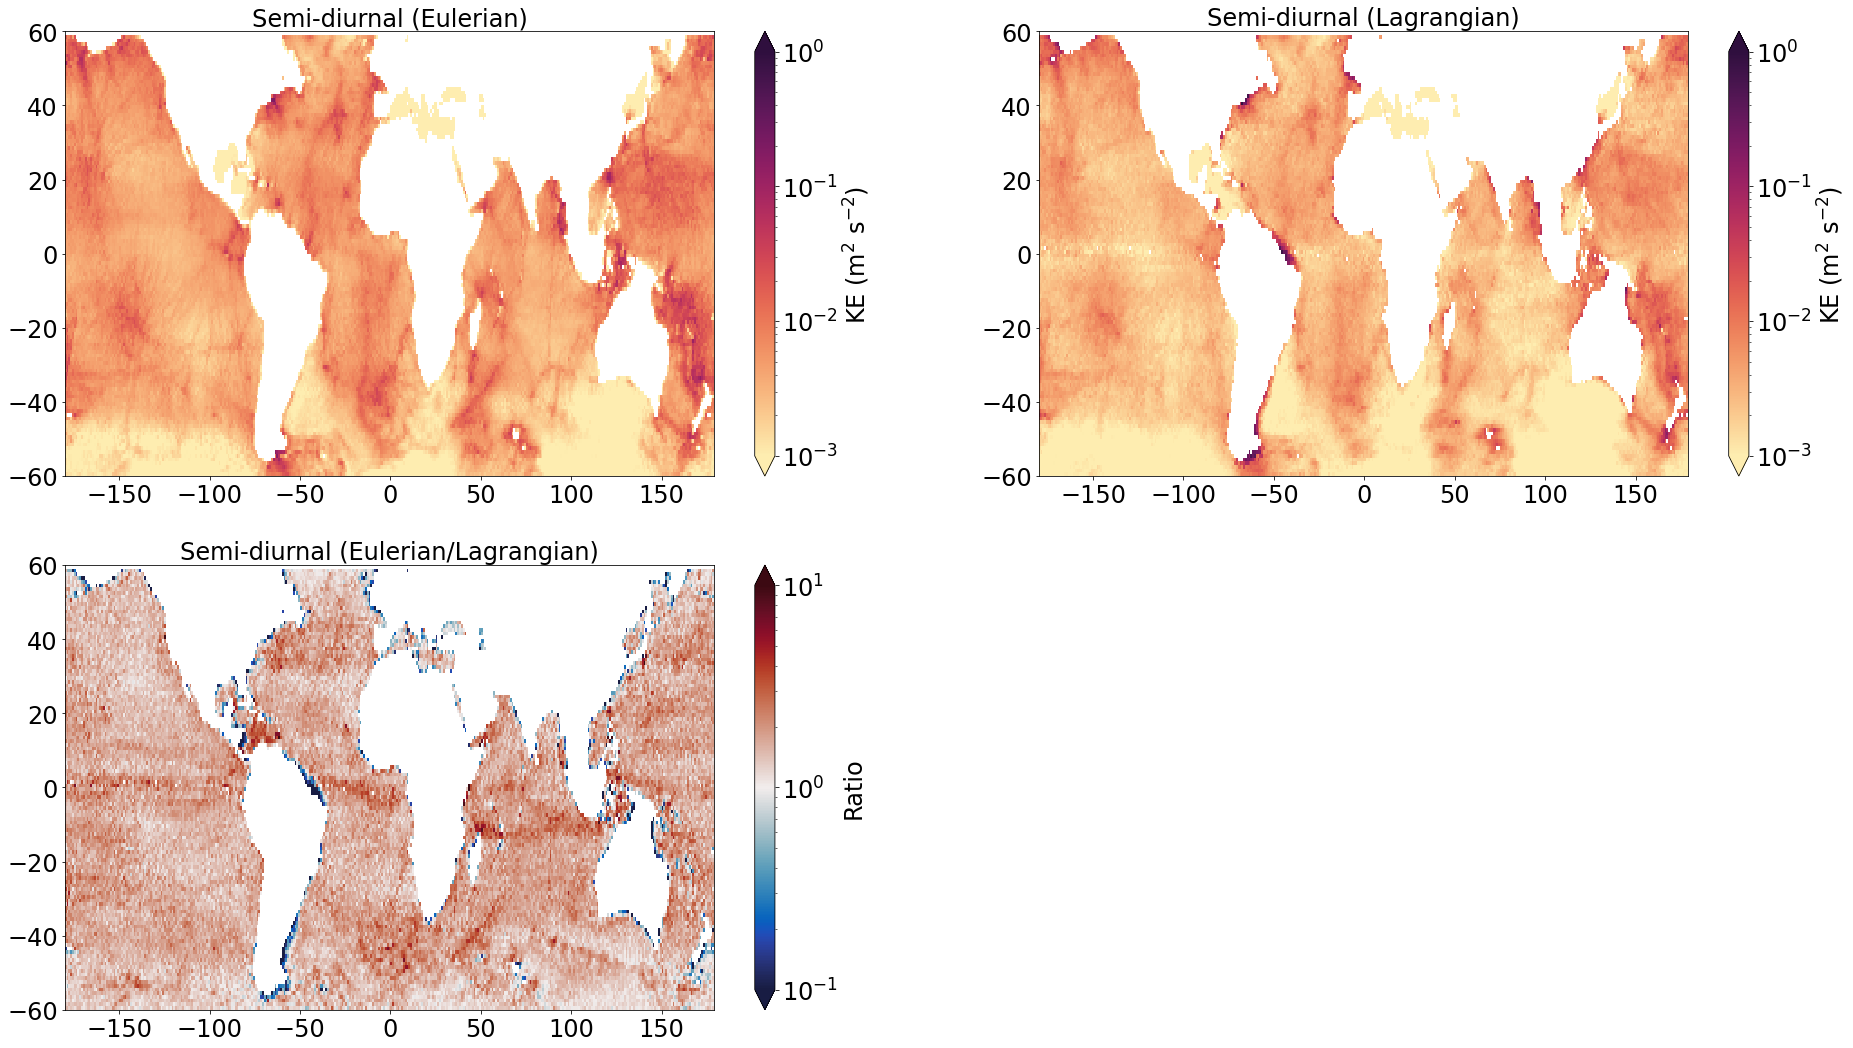

In [58]:
# bandwidth +-0.1
font_size = 24
fig, ax = plt.subplots(figsize=(32,18))

ax = plt.subplot(221)
cax=(ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot1')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e0), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Semi-diurnal (Eulerian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)


ax = plt.subplot(222)
cax=(ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot1')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e0), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Semi-diurnal (Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)


ax = plt.subplot(223)
cax = (ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot1')/ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot1')).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Semi-diurnal (Eulerian/Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)


Text(0.5, 0, '')

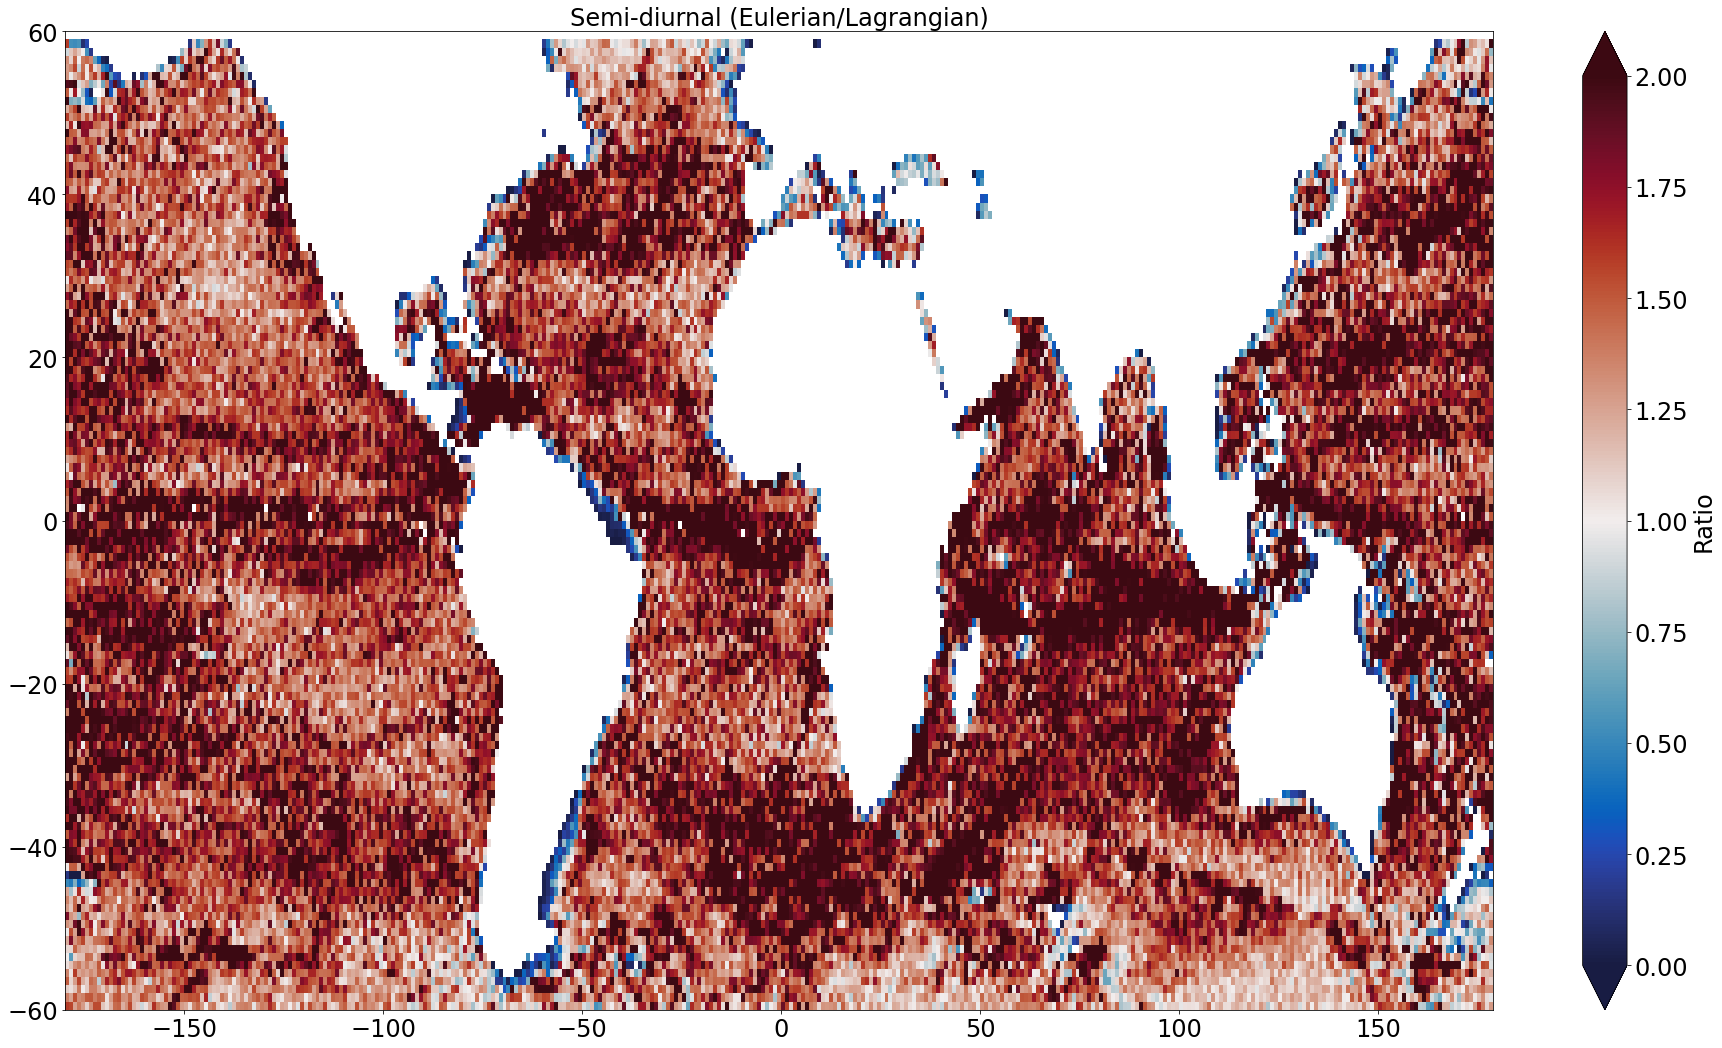

In [9]:
# bandwidth +-0.1
font_size = 24
fig, ax = plt.subplots(figsize=(32,18))


ax = plt.subplot(111)
cax = (E_Eulerian.E_SSUV.sel(frequency_band='semidiurnal_0dot1')/E_lagrangian.sel(frequency_band='semidiurnal_0dot1')).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, vmin=0, vmax=2, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Semi-diurnal (Eulerian/Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)


Text(0.5, 0, '')

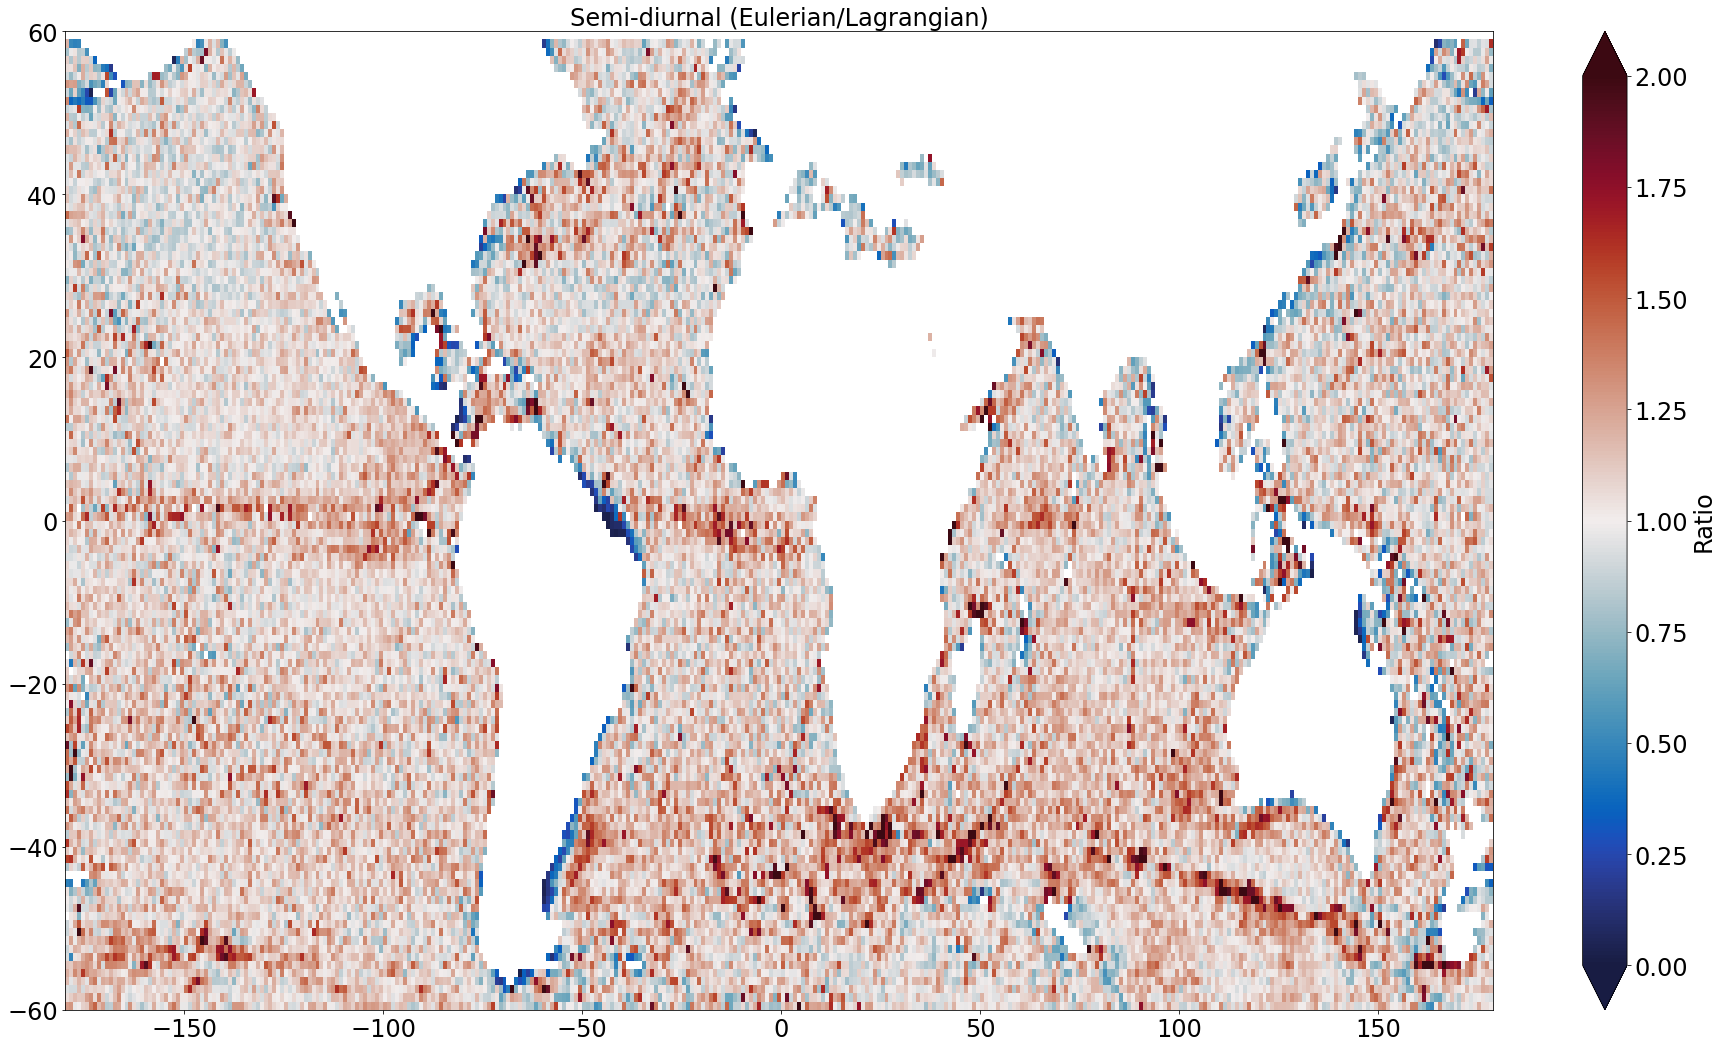

In [42]:
# bandwidth +-0.1
font_size = 24
fig, ax = plt.subplots(figsize=(32,18))


ax = plt.subplot(111)
cax = (ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot4')/ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot4')).where(ds_E.E_depth>1000).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, vmin=0, vmax=2, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Semi-diurnal (Eulerian/Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)


In [64]:
ds_E

<xarray.Dataset>
Dimensions:         (frequency_band: 14, lat_bins: 119, lon_bins: 359)
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'
  * lat_bins        (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5
  * lon_bins        (lon_bins) float64 -179.5 -178.5 -177.5 ... 177.5 178.5
Data variables:
    E_Eulerian      (frequency_band, lon_bins, lat_bins) float64 dask.array<chunksize=(7, 180, 60), meta=np.ndarray>
    E_Lagrangian    (frequency_band, lon_bins, lat_bins) float64 dask.array<chunksize=(1, 359, 60), meta=np.ndarray>
    E_depth         (lon_bins, lat_bins) float64 4.548e+03 ... 3.74e+03

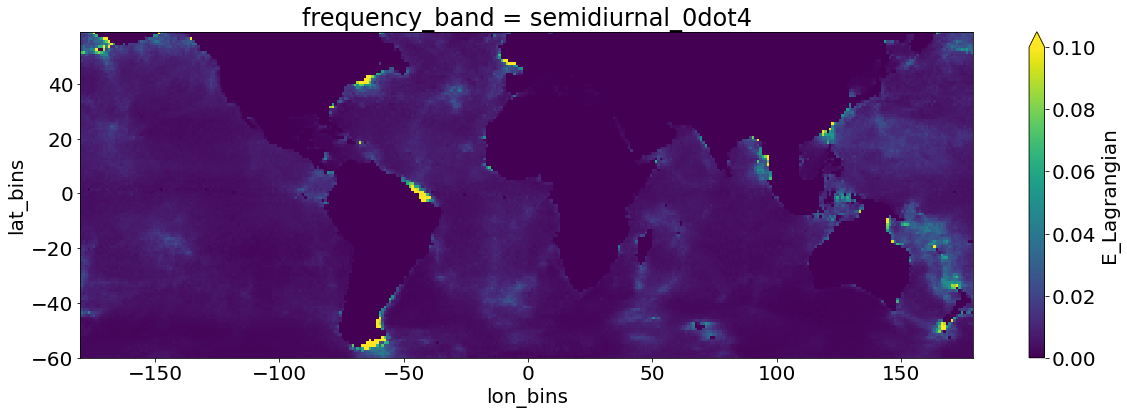

In [64]:
fig, ax = plt.subplots(figsize=(20,6))
ax = plt.subplot(111)
ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot4').plot(x='lon_bins', vmin=0,vmax=0.1)

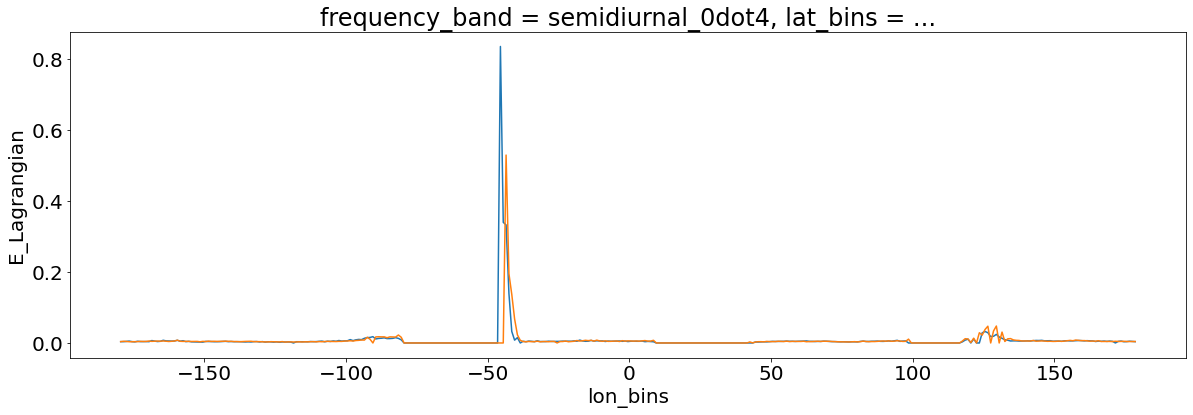

In [72]:
fig, ax = plt.subplots(figsize=(20,6))
ax = plt.subplot(111)
ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot4').sel(lat_bins=0.5).plot()
ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot4').sel(lat_bins=-0.5).plot()

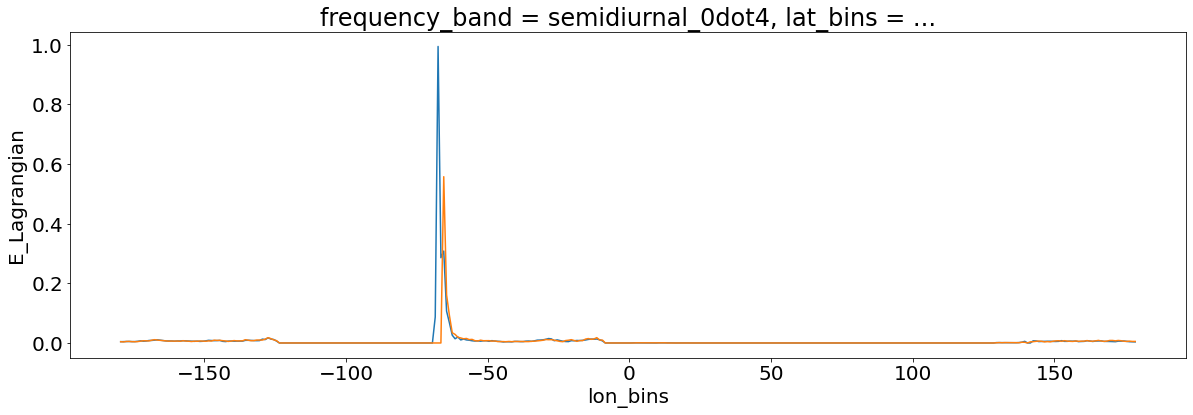

In [73]:
fig, ax = plt.subplots(figsize=(20,6))
ax = plt.subplot(111)
ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot4').sel(lat_bins=40.5).plot()
ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot4').sel(lat_bins=41.5).plot()

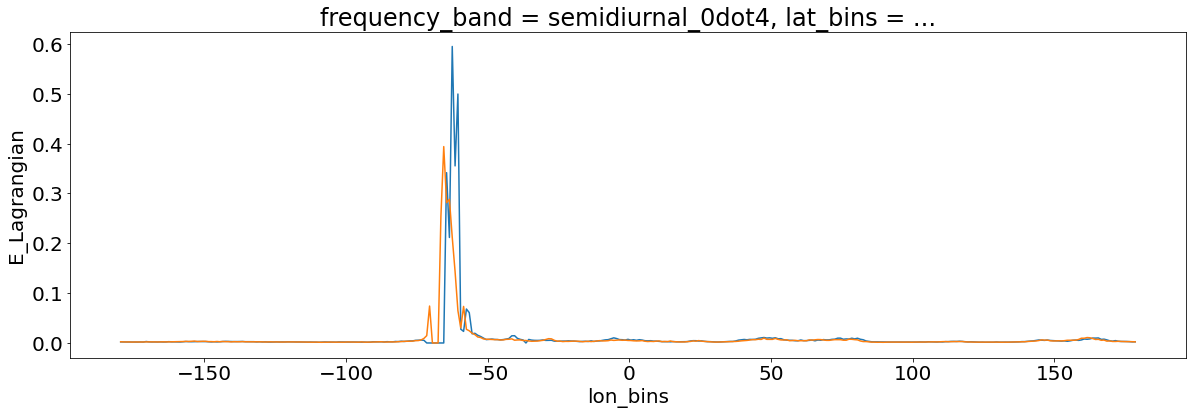

In [75]:
fig, ax = plt.subplots(figsize=(20,6))
ax = plt.subplot(111)
ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot4').sel(lat_bins=-54.5).plot()
ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot4').sel(lat_bins=-55.5).plot()

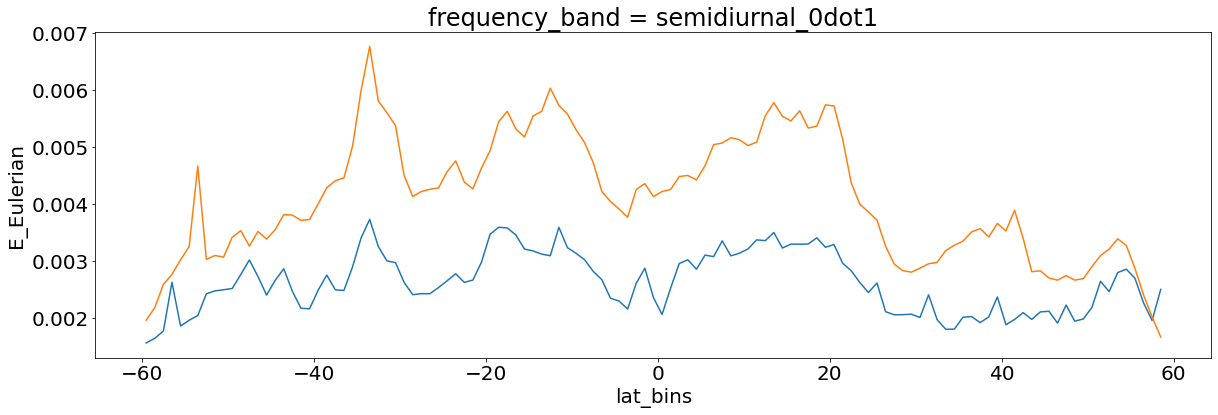

In [69]:
L_semi = ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot1')
fig, ax = plt.subplots(figsize=(20,6))
ax = plt.subplot(111)
L_semi.where(L_semi<0.1).mean('lon_bins').plot()
ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot1').mean('lon_bins').plot()


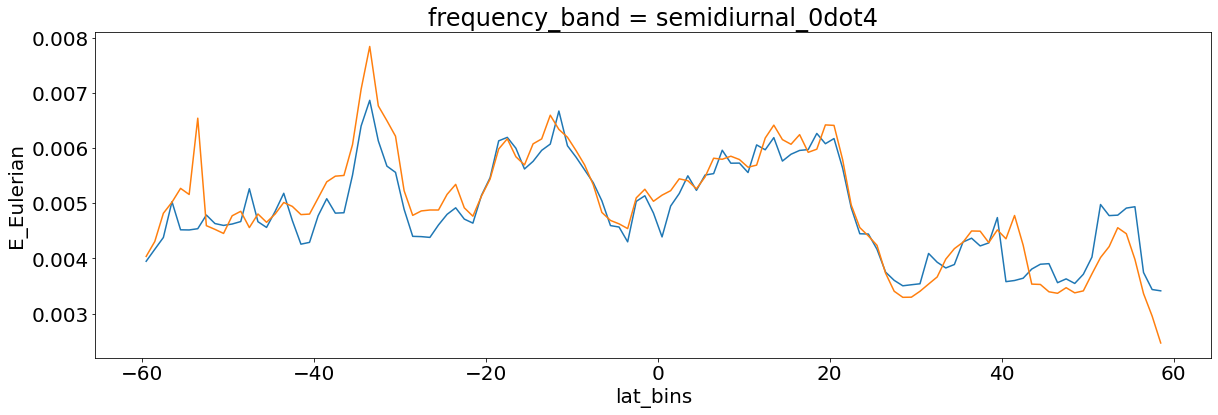

In [71]:
L_semi = ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot4')
fig, ax = plt.subplots(figsize=(20,6))
ax = plt.subplot(111)
L_semi.where(L_semi<0.1).mean('lon_bins').plot()
ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot4').mean('lon_bins').plot()


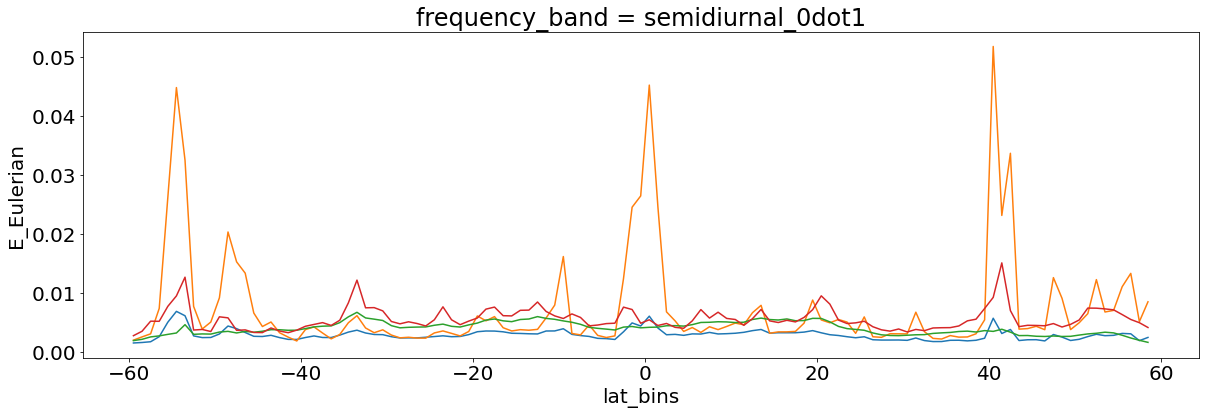

In [76]:
L_semi = ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot4')
fig, ax = plt.subplots(figsize=(20,6))
ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot1').mean('lon_bins').plot()
ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot1').std('lon_bins').plot()
ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot1').mean('lon_bins').plot()
ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot1').std('lon_bins').plot()

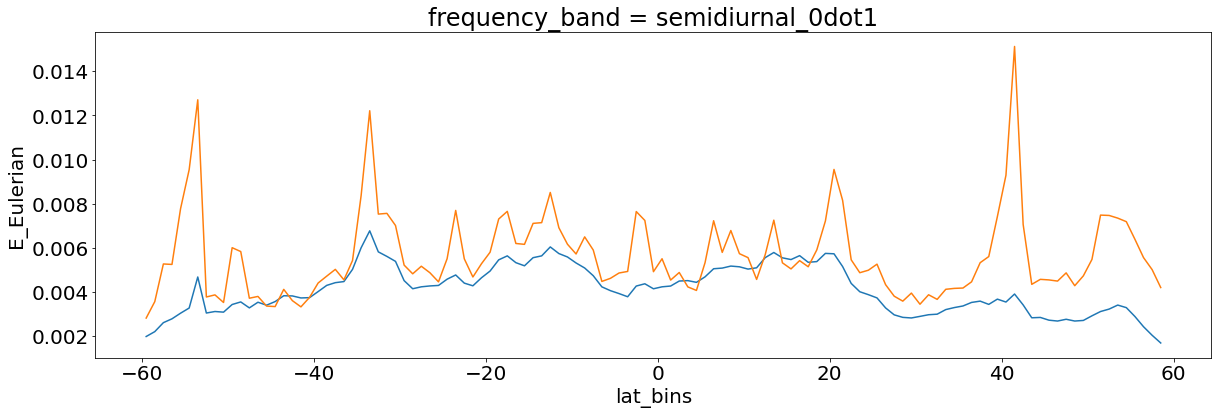

In [77]:
L_semi = ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot4')
fig, ax = plt.subplots(figsize=(20,6))
ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot1').mean('lon_bins').plot()
ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot1').std('lon_bins').plot()

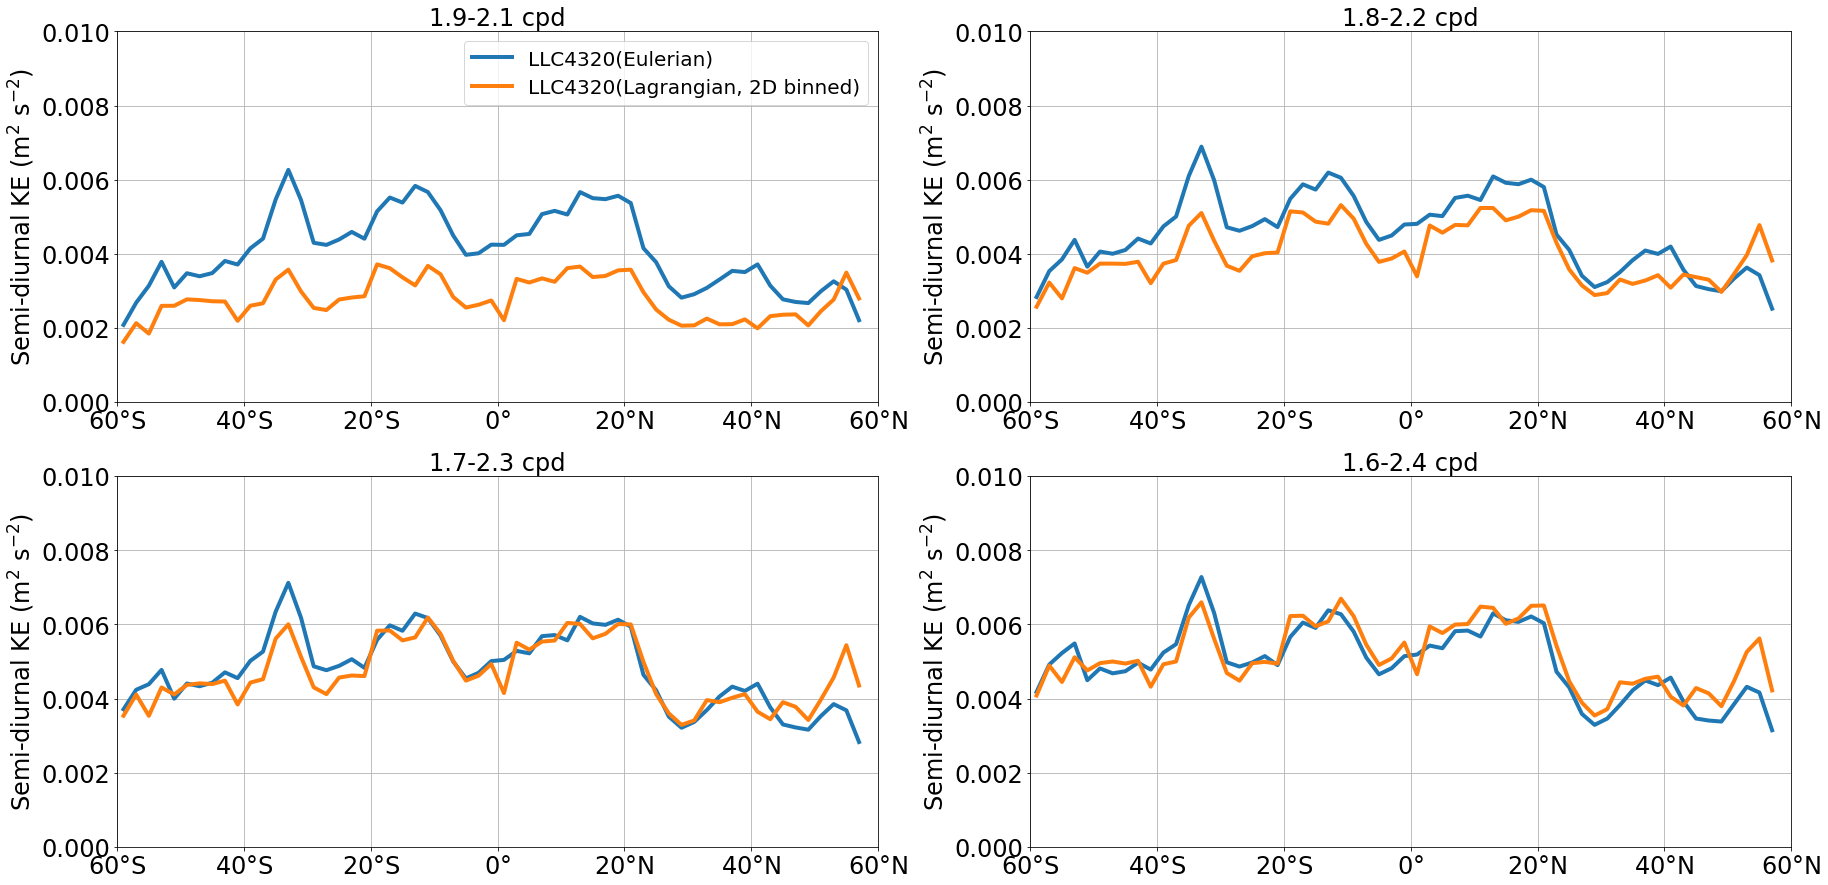

In [99]:
# compare each component by applying windowing
labels = ['LLC4320(Eulerian)', 'LLC4320(Lagrangian, 2D binned)']

fig, ax = plt.subplots(figsize=(30,15))

ax = plt.subplot(2,2,1)
ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot1').mean('lon_bins').plot(color='tab:blue', label=labels[0], linewidth=4)
ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<0.1).sel(frequency_band='semidiurnal_0dot1').mean('lon_bins').plot(color='tab:orange', label=labels[1], linewidth=4)
ax.legend(prop={'size': 20}); 
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylim([0,0.01])
# Label, size
ax.set_xlabel('',fontsize=24)
ax.set_ylabel('Semi-diurnal KE (m$^2$ s$^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('1.9-2.1 cpd',fontsize=24)

ax = plt.subplot(2,2,2)
ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot2').mean('lon_bins').plot(color='tab:blue', label=labels[0], linewidth=4)
ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<0.1).sel(frequency_band='semidiurnal_0dot2').mean('lon_bins').plot(color='tab:orange', label=labels[1], linewidth=4)
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylim([0,0.01])
# Label, size
ax.set_xlabel('',fontsize=24)
ax.set_ylabel('Semi-diurnal KE (m$^2$ s$^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('1.8-2.2 cpd',fontsize=24)

ax = plt.subplot(2,2,3)
ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot3').mean('lon_bins').plot(color='tab:blue', label=labels[0], linewidth=4)
ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<0.1).sel(frequency_band='semidiurnal_0dot3').mean('lon_bins').plot(color='tab:orange', label=labels[1], linewidth=4)
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylim([0,0.01])
# Label, size
ax.set_xlabel('',fontsize=24)
ax.set_ylabel('Semi-diurnal KE (m$^2$ s$^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('1.7-2.3 cpd',fontsize=24)


ax = plt.subplot(2,2,4)
ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot4').mean('lon_bins').plot(color='tab:blue', label=labels[0], linewidth=4)
ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<0.1).sel(frequency_band='semidiurnal_0dot4').mean('lon_bins').plot(color='tab:orange', label=labels[1], linewidth=4)
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylim([0,0.01])
# Label, size
ax.set_xlabel('',fontsize=24)
ax.set_ylabel('Semi-diurnal KE (m$^2$ s$^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('1.6-2.4 cpd',fontsize=24)


plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Band_integral_LLC_Eulerian_Lagrangian_bandwidth_semidiurnal_improved.png')

Text(0, 0.5, 'Lagrangian ')

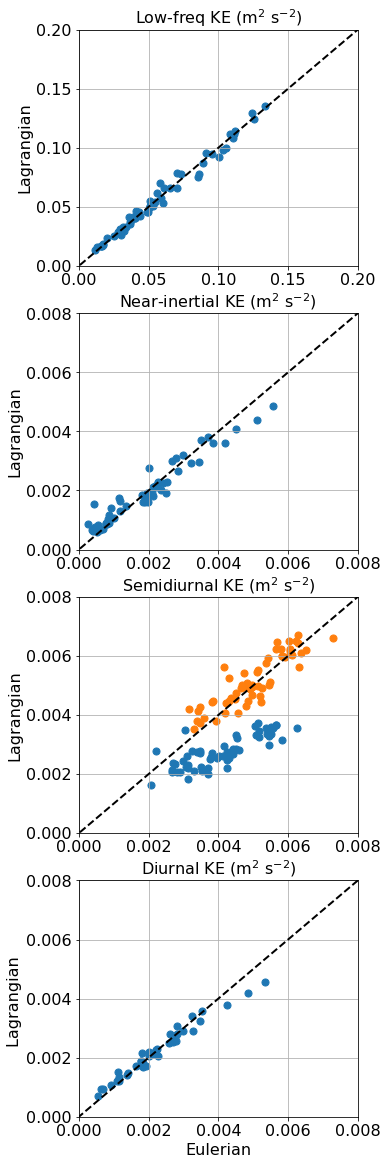

In [102]:
# bandwidth +-0.1 cpd
lims = (-.5, .5)
font_size=16

fig, ax = plt.subplots(1,1,figsize=(5,20))
ax = plt.subplot(411)
ax.scatter( ds_E.E_Eulerian.sel(frequency_band='low').mean('lon_bins'), 
            ds_E.E_Lagrangian.sel(frequency_band='low').mean('lon_bins'), 
            s=50)
ax.grid(); ax.set_xlim(0.,0.2); ax.set_ylim(0.,0.2)
ax.plot(lims, lims, color="k", ls="--", linewidth=2)
ax.set_title('Low-freq KE (m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('Lagrangian',fontsize=font_size)

ax = plt.subplot(412)
ax.scatter( ds_E.E_Eulerian.sel(frequency_band='diurnal_0dot1').mean('lon_bins'), 
            ds_E.E_Lagrangian.sel(frequency_band='diurnal_0dot1').mean('lon_bins'), 
            s=50)
ax.grid(); ax.set_xlim(0.,0.008); ax.set_ylim(0.,0.008)
ax.plot(lims, lims, color="k", ls="--", linewidth=2)
ax.set_title('Near-inertial KE (m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('Lagrangian',fontsize=font_size)

ax = plt.subplot(413)
ax.scatter( ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot1').mean('lon_bins'), 
            ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<0.1).sel(frequency_band='semidiurnal_0dot1').mean('lon_bins'), 
            s=50)
ax.scatter( ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot4').mean('lon_bins'), 
            ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<0.1).sel(frequency_band='semidiurnal_0dot4').mean('lon_bins'), 
            s=50)
ax.grid(); ax.set_xlim(0.,0.008); ax.set_ylim(0.,0.008)
ax.plot(lims, lims, color="k", ls="--", linewidth=2)
ax.set_title('Semidiurnal KE (m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('Lagrangian',fontsize=font_size)

ax = plt.subplot(414)
ax.scatter( ds_E.E_Eulerian.where(np.abs(ds_E.lat_bins)>15).sel(frequency_band='inertial_0dot1').mean('lon_bins'), 
            ds_E.E_Lagrangian.where(np.abs(ds_E.lat_bins)>15).sel(frequency_band='inertial_0dot1').mean('lon_bins'), 
            s=50)
ax.grid(); ax.set_xlim(0.,0.008); ax.set_ylim(0.,0.008)
ax.plot(lims, lims, color="k", ls="--", linewidth=2)
ax.set_title('Diurnal KE (m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.set_ylabel('Lagrangian ',fontsize=font_size)

#plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Band_integral_LLC_Eulerian_Lagrangian_each_0dot1_scatter.png')

_____________
# 2 degree binning

______________
## lat*lon maps

In [83]:
E_Eulerian = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T60_lat_lon_bands_2deg.zarr'))
E_Eulerian = (E_Eulerian.rename({'lat_bin':'lat_bins', 'lon_bin': 'lon_bins', 'E_SSUV':'E_Eulerian'}))
E_Eulerian

<xarray.Dataset>
Dimensions:         (frequency_band: 14, lat_bins: 59, lon_bins: 179)
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'
  * lat_bins        (lat_bins) float64 -59.0 -57.0 -55.0 ... 53.0 55.0 57.0
  * lon_bins        (lon_bins) float64 -179.0 -177.0 -175.0 ... 175.0 177.0
Data variables:
    E_Eulerian      (frequency_band, lon_bins, lat_bins) float64 dask.array<chunksize=(7, 90, 59), meta=np.ndarray>

In [84]:
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['trajectory'])
E_lagrangian = p.load_diagnostic('spectra_uv_T60_mean0_lat_lon_bands_2deg.zarr')
E_lagrangian = E_lagrangian.rename({'E':'E_Lagrangian'})
E_lagrangian = E_lagrangian.E_Lagrangian
E_lagrangian

<xarray.DataArray 'E_Lagrangian' (frequency_band: 14, lon_bins: 179, lat_bins: 59)>
dask.array<open_dataset-4d37866eccf67182f5ad97690f88aa3dE, shape=(14, 179, 59), dtype=float64, chunksize=(1, 179, 30), chunktype=numpy.ndarray>
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'
  * lat_bins        (lat_bins) float64 -59.0 -57.0 -55.0 ... 53.0 55.0 57.0
  * lon_bins        (lon_bins) float64 -179.0 -177.0 -175.0 ... 175.0 177.0

In [85]:
ds_E = xr.merge([E_Eulerian,E_lagrangian])
ds_E

<xarray.Dataset>
Dimensions:         (frequency_band: 14, lat_bins: 59, lon_bins: 179)
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'
  * lat_bins        (lat_bins) float64 -59.0 -57.0 -55.0 ... 53.0 55.0 57.0
  * lon_bins        (lon_bins) float64 -179.0 -177.0 -175.0 ... 175.0 177.0
Data variables:
    E_Eulerian      (frequency_band, lon_bins, lat_bins) float64 dask.array<chunksize=(7, 90, 59), meta=np.ndarray>
    E_Lagrangian    (frequency_band, lon_bins, lat_bins) float64 dask.array<chunksize=(1, 179, 30), meta=np.ndarray>

## 2D Histogram

In [87]:
x_bins = np.arange(0, 0.025, 0.001)
y_bins = np.arange(0, 0.025, 0.001)

SD_01cpd = histogram(ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot1'),
                     ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot1'),
                     bins=[x_bins, y_bins],
                     block_size=None)

SD_02cpd = histogram(ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot2'),
                     ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot2'),
                     bins=[x_bins, y_bins],
                     block_size=None)

SD_03cpd = histogram(ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot3'),
                     ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot3'),
                     bins=[x_bins, y_bins],
                     block_size=None)

SD_04cpd = histogram(ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot4'),
                     ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot4'),
                     bins=[x_bins, y_bins],
                     block_size=None)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


Text(0.5, 1.0, '$\\pm$0.4 cpd')

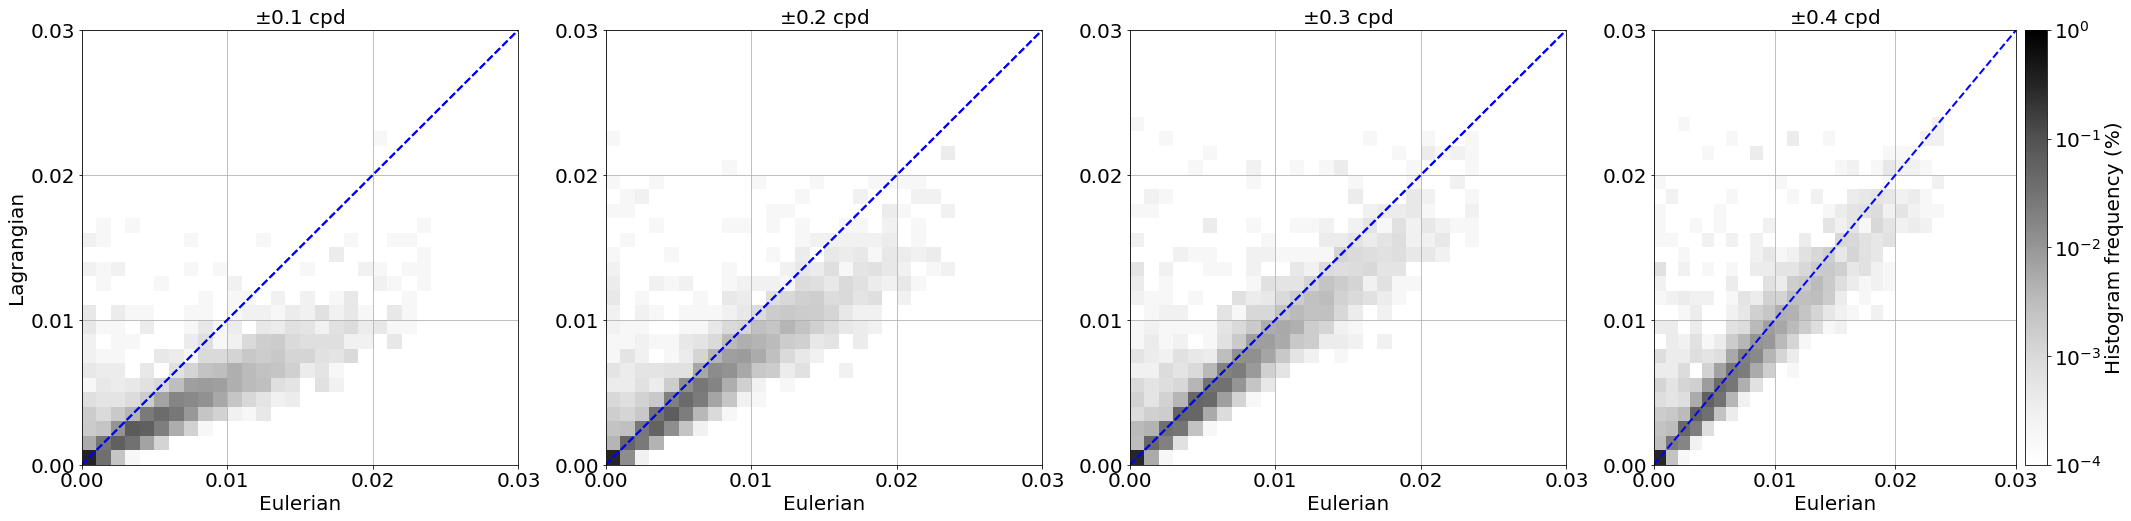

In [88]:
# Histogram for lat*lon KE
plt.rc('font', size=20) 
font_size = 20
vmin = -4
vmax = 0
cmap = 'Greys'
color = "b"
lims = (0, .03)


fig = plt.figure(figsize=(36,8))
ax = plt.subplot(141)
cax = np.log10(SD_01cpd/SD_01cpd.sum()).plot(x='E_Eulerian_bin',y='E_Lagrangian_bin',cmap=cmap,vmin=vmin,vmax=vmax, add_colorbar = False) 
ax.grid()
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel('Lagrangian',fontsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xticks([0, 0.01,0.02,0.03])
ax.set_yticks([0, 0.01,0.02,0.03])
ax.set_title('$\pm$0.1 cpd',fontsize=font_size)

ax = plt.subplot(142)
cax = np.log10(SD_02cpd/SD_02cpd.sum()).plot(x='E_Eulerian_bin',y='E_Lagrangian_bin',cmap=cmap,vmin=vmin,vmax=vmax, add_colorbar = False) 
ax.grid()
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xticks([0, 0.01,0.02,0.03])
ax.set_yticks([0, 0.01,0.02,0.03])
ax.set_title('$\pm$0.2 cpd',fontsize=font_size)

ax = plt.subplot(143)
cax = np.log10(SD_03cpd/SD_03cpd.sum()).plot(x='E_Eulerian_bin',y='E_Lagrangian_bin',cmap=cmap,vmin=vmin,vmax=vmax, add_colorbar = False) 
ax.grid()
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xticks([0, 0.01,0.02,0.03])
ax.set_yticks([0, 0.01,0.02,0.03])
ax.set_title('$\pm$0.3 cpd',fontsize=font_size)

ax = plt.subplot(144)
cax = np.log10(SD_04cpd/SD_04cpd.sum()).plot(x='E_Eulerian_bin',y='E_Lagrangian_bin',cmap=cmap,vmin=vmin,vmax=vmax, add_colorbar = False) 
cbar = plt.colorbar(cax, ax=ax, orientation='vertical', ticks=[-4, -3, -2, -1, 0], pad=0.02)
cbar.set_ticklabels(['10$^{-4}$','10$^{-3}$','10$^{-2}$','10$^{-1}$','10$^{0}$'])
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Histogram frequency (%)', fontsize=font_size)
ax.grid()
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xticks([0, 0.01,0.02,0.03])
ax.set_yticks([0, 0.01,0.02,0.03])
ax.set_title('$\pm$0.4 cpd',fontsize=font_size)

#plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/KE_2D_histogram_SD.png')

In [89]:
x_bins = np.arange(0, 0.025, 0.001)
y_bins = np.arange(0, 0.025, 0.001)

D_01cpd = histogram(ds_E.E_Eulerian.sel(frequency_band='diurnal_0dot1'),
                     ds_E.E_Lagrangian.sel(frequency_band='diurnal_0dot1'),
                     bins=[x_bins, y_bins],
                     block_size=None)

D_02cpd = histogram(ds_E.E_Eulerian.sel(frequency_band='diurnal_0dot2'),
                     ds_E.E_Lagrangian.sel(frequency_band='diurnal_0dot2'),
                     bins=[x_bins, y_bins],
                     block_size=None)

D_03cpd = histogram(ds_E.E_Eulerian.sel(frequency_band='diurnal_0dot3'),
                     ds_E.E_Lagrangian.sel(frequency_band='diurnal_0dot3'),
                     bins=[x_bins, y_bins],
                     block_size=None)

D_04cpd = histogram(ds_E.E_Eulerian.sel(frequency_band='diurnal_0dot4'),
                     ds_E.E_Lagrangian.sel(frequency_band='diurnal_0dot4'),
                     bins=[x_bins, y_bins],
                     block_size=None)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


Text(0.5, 1.0, '$\\pm$0.4 cpd')

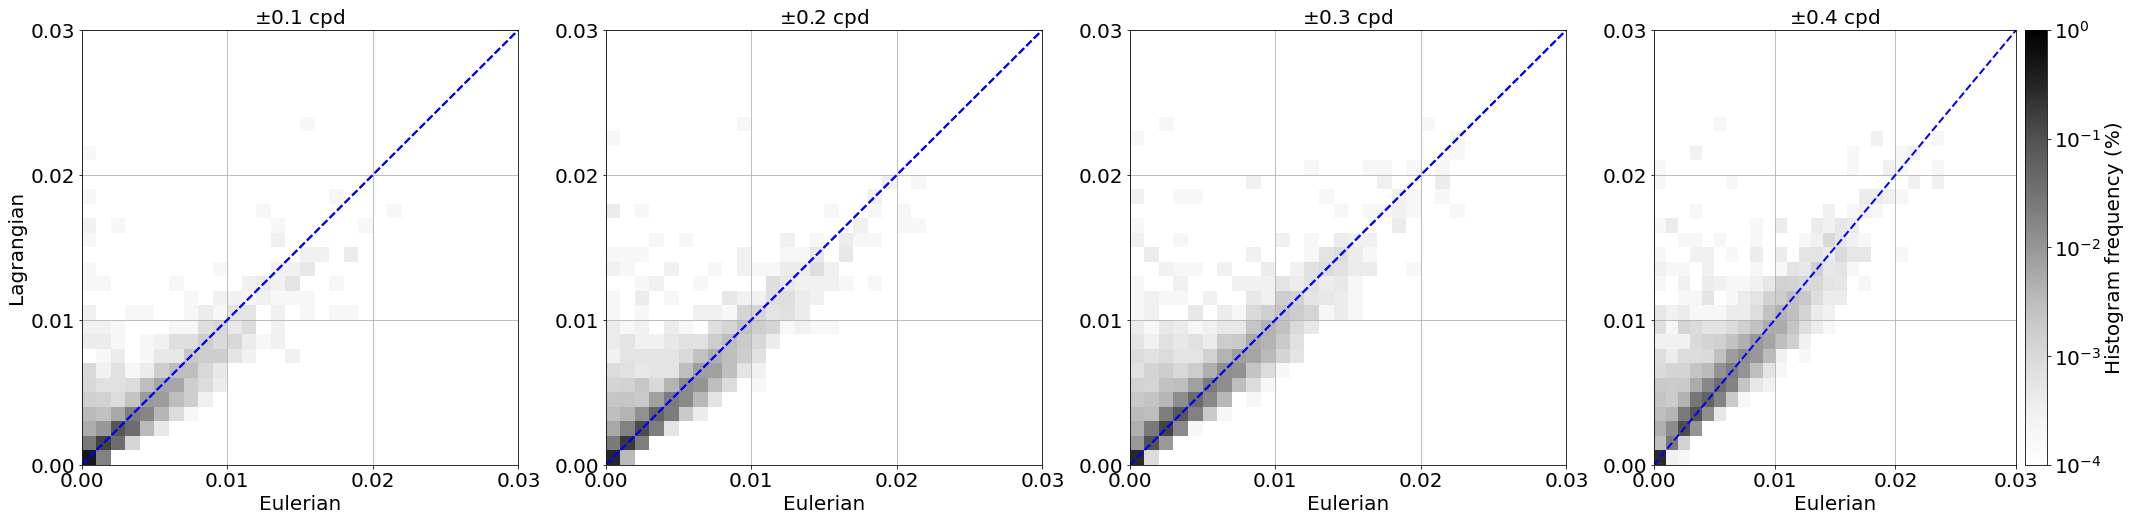

In [90]:
# Histogram for lat*lon KE
plt.rc('font', size=20) 
font_size = 20
vmin = -4
vmax = 0
cmap = 'Greys'
color = "b"
lims = (0, .03)

fig = plt.figure(figsize=(36,8))
ax = plt.subplot(141)
cax = np.log10(D_01cpd/SD_01cpd.sum()).plot(x='E_Eulerian_bin',y='E_Lagrangian_bin',cmap=cmap,vmin=vmin,vmax=vmax, add_colorbar = False) 
ax.grid()
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel('Lagrangian',fontsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xticks([0, 0.01,0.02,0.03])
ax.set_yticks([0, 0.01,0.02,0.03])
ax.set_title('$\pm$0.1 cpd',fontsize=font_size)

ax = plt.subplot(142)
cax = np.log10(D_02cpd/SD_02cpd.sum()).plot(x='E_Eulerian_bin',y='E_Lagrangian_bin',cmap=cmap,vmin=vmin,vmax=vmax, add_colorbar = False) 
ax.grid()
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xticks([0, 0.01,0.02,0.03])
ax.set_yticks([0, 0.01,0.02,0.03])
ax.set_title('$\pm$0.2 cpd',fontsize=font_size)

ax = plt.subplot(143)
cax = np.log10(D_03cpd/SD_03cpd.sum()).plot(x='E_Eulerian_bin',y='E_Lagrangian_bin',cmap=cmap,vmin=vmin,vmax=vmax, add_colorbar = False) 
ax.grid()
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xticks([0, 0.01,0.02,0.03])
ax.set_yticks([0, 0.01,0.02,0.03])
ax.set_title('$\pm$0.3 cpd',fontsize=font_size)

ax = plt.subplot(144)
cax = np.log10(D_04cpd/SD_04cpd.sum()).plot(x='E_Eulerian_bin',y='E_Lagrangian_bin',cmap=cmap,vmin=vmin,vmax=vmax, add_colorbar = False) 
cbar = plt.colorbar(cax, ax=ax, orientation='vertical', ticks=[-4, -3, -2, -1, 0], pad=0.02)
cbar.set_ticklabels(['10$^{-4}$','10$^{-3}$','10$^{-2}$','10$^{-1}$','10$^{0}$'])
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Histogram frequency (%)', fontsize=font_size)
ax.grid()
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xticks([0, 0.01,0.02,0.03])
ax.set_yticks([0, 0.01,0.02,0.03])
ax.set_title('$\pm$0.4 cpd',fontsize=font_size)

#plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/KE_2D_histogram_D.png')

In [91]:
x_bins = np.arange(0, 0.025, 0.001)
y_bins = np.arange(0, 0.025, 0.001)

NI_01cpd = histogram(ds_E.E_Eulerian.sel(frequency_band='inertial_0dot1').where(np.abs(ds_E.lat_bins)>15),
                     ds_E.E_Lagrangian.sel(frequency_band='inertial_0dot1').where(np.abs(ds_E.lat_bins)>15),
                     bins=[x_bins, y_bins],
                     block_size=None)

NI_02cpd = histogram(ds_E.E_Eulerian.sel(frequency_band='inertial_0dot2').where(np.abs(ds_E.lat_bins)>15),
                     ds_E.E_Lagrangian.sel(frequency_band='inertial_0dot2').where(np.abs(ds_E.lat_bins)>15),
                     bins=[x_bins, y_bins],
                     block_size=None)

NI_03cpd = histogram(ds_E.E_Eulerian.sel(frequency_band='inertial_0dot3').where(np.abs(ds_E.lat_bins)>15),
                     ds_E.E_Lagrangian.sel(frequency_band='inertial_0dot3').where(np.abs(ds_E.lat_bins)>15),
                     bins=[x_bins, y_bins],
                     block_size=None)

NI_04cpd = histogram(ds_E.E_Eulerian.sel(frequency_band='inertial_0dot4').where(np.abs(ds_E.lat_bins)>15),
                     ds_E.E_Lagrangian.sel(frequency_band='inertial_0dot4').where(np.abs(ds_E.lat_bins)>15),
                     bins=[x_bins, y_bins],
                     block_size=None)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


Text(0.5, 1.0, '$\\pm$0.4 cpd')

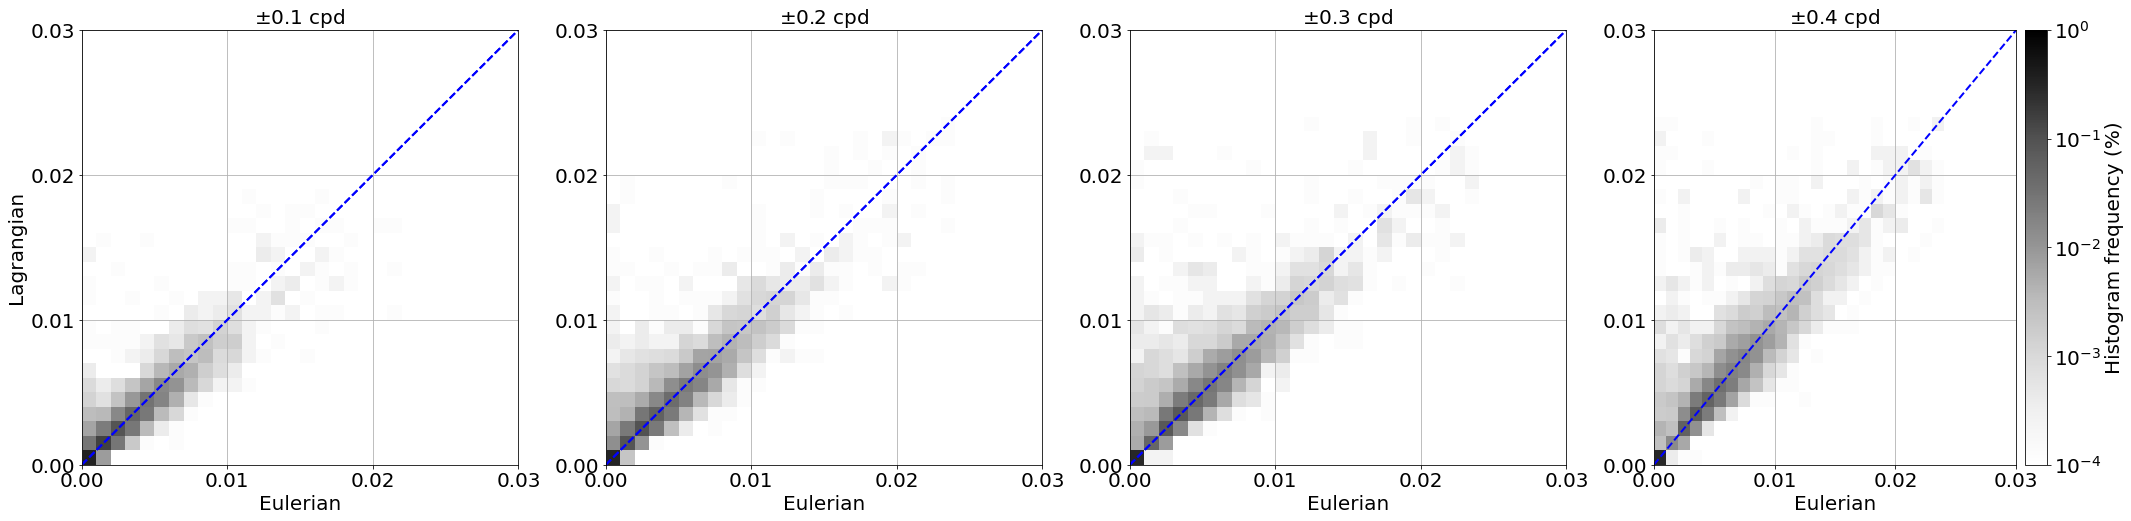

In [92]:
# Histogram for lat*lon KE
plt.rc('font', size=20) 
font_size = 20
vmin = -4
vmax = 0
cmap = 'Greys'
color = "b"
lims = (0, .03)

fig = plt.figure(figsize=(36,8))
ax = plt.subplot(141)
cax = np.log10(NI_01cpd/NI_01cpd.sum()).plot(x='E_Eulerian_bin',y='E_Lagrangian_bin',cmap=cmap,vmin=vmin,vmax=vmax, add_colorbar = False) 
ax.grid()
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel('Lagrangian',fontsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xticks([0, 0.01,0.02,0.03])
ax.set_yticks([0, 0.01,0.02,0.03])
ax.set_title('$\pm$0.1 cpd',fontsize=font_size)

ax = plt.subplot(142)
cax = np.log10(NI_02cpd/NI_02cpd.sum()).plot(x='E_Eulerian_bin',y='E_Lagrangian_bin',cmap=cmap,vmin=vmin,vmax=vmax, add_colorbar = False) 
ax.grid()
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xticks([0, 0.01,0.02,0.03])
ax.set_yticks([0, 0.01,0.02,0.03])
ax.set_title('$\pm$0.2 cpd',fontsize=font_size)

ax = plt.subplot(143)
cax = np.log10(NI_03cpd/NI_03cpd.sum()).plot(x='E_Eulerian_bin',y='E_Lagrangian_bin',cmap=cmap,vmin=vmin,vmax=vmax, add_colorbar = False) 
ax.grid()
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xticks([0, 0.01,0.02,0.03])
ax.set_yticks([0, 0.01,0.02,0.03])
ax.set_title('$\pm$0.3 cpd',fontsize=font_size)

ax = plt.subplot(144)
cax = np.log10(NI_04cpd/NI_04cpd.sum()).plot(x='E_Eulerian_bin',y='E_Lagrangian_bin',cmap=cmap,vmin=vmin,vmax=vmax, add_colorbar = False) 
cbar = plt.colorbar(cax, ax=ax, orientation='vertical', ticks=[-4, -3, -2, -1, 0], pad=0.02)
cbar.set_ticklabels(['10$^{-4}$','10$^{-3}$','10$^{-2}$','10$^{-1}$','10$^{0}$'])
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Histogram frequency (%)', fontsize=font_size)
ax.grid()
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xticks([0, 0.01,0.02,0.03])
ax.set_yticks([0, 0.01,0.02,0.03])
ax.set_title('$\pm$0.4 cpd',fontsize=font_size)

#plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/KE_2D_histogram_NI.png')

In [86]:
ds_E.load()

<xarray.Dataset>
Dimensions:         (frequency_band: 14, lat_bins: 59, lon_bins: 179)
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'
  * lat_bins        (lat_bins) float64 -59.0 -57.0 -55.0 ... 53.0 55.0 57.0
  * lon_bins        (lon_bins) float64 -179.0 -177.0 -175.0 ... 175.0 177.0
Data variables:
    E_Eulerian      (frequency_band, lon_bins, lat_bins) float64 0.0921 ... 0...
    E_Lagrangian    (frequency_band, lon_bins, lat_bins) float64 0.08628 ... ...

In [95]:
R = xr.corr(ds_E.E_Eulerian,
            ds_E.E_Lagrangian,
            dim=['lat_bins','lon_bins']
           )
R.values

array([0.86555184, 0.88235699, 0.77089   , 0.80866737, 0.82152322,
       0.82678235, 0.35766251, 0.42135181, 0.45709775, 0.47779766,
       0.91533244, 0.90804149, 0.87191827, 0.85243904])

In [96]:
# exclude 15S - 15N
R = xr.corr(ds_E.E_Eulerian.where(np.abs(ds_E.lat_bins)>15),
            ds_E.E_Lagrangian.where(np.abs(ds_E.lat_bins)>15),
            dim=['lat_bins','lon_bins']
           )
R.values

array([0.88753379, 0.90803799, 0.82538535, 0.84798496, 0.85314838,
       0.85306624, 0.40177134, 0.45952253, 0.49099398, 0.50977729,
       0.92863045, 0.89080834, 0.67382245, 0.63916258])

## Close cluster

In [105]:
cluster.close()